# Conexión a Google Drive

In [1]:
# https://drive.google.com/file/d/1Tzob7KxXtzyEcj5Wp8Ff-5j3exfA1e7x/view?usp=sharing
!gdown 1Tzob7KxXtzyEcj5Wp8Ff-5j3exfA1e7x

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Tzob7KxXtzyEcj5Wp8Ff-5j3exfA1e7x 



In [15]:
import zipfile
zip_ref = zipfile.ZipFile("/content/Prototipo.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [18]:
import os
for path, x, zips in os.walk('/content/Prototipo/Train/TratamientoDatos'):
    for zip in zips:
        if '.zip' in zip:
            zip_ref = zipfile.ZipFile(os.path.join(path, zip), 'r')
            zip_ref.extractall(os.path.join(path))
            zip_ref.close()

In [22]:
import os
for path, x, files in os.walk('/content/Prototipo/'):
    for file in files:
        if '.ini' in file:
            file_temp = os.path.join(path, file)
            print(file_temp)
            os.remove(file_temp)

/content/Prototipo/desktop.ini
/content/Prototipo/Train/desktop.ini
/content/Prototipo/Train/TratamientoDatos/desktop.ini
/content/Prototipo/Train/TratamientoDatos/SFAS/desktop.ini
/content/Prototipo/Train/TratamientoDatos/SFAS/SUBSTITUTION/desktop.ini
/content/Prototipo/Train/TratamientoDatos/SFAS/CASIA/desktop.ini
/content/Prototipo/Train/TratamientoDatos/SFAS/StyleGAN/desktop.ini
/content/Prototipo/Train/TratamientoDatos/SFAS/DIFFUSION/desktop.ini
/content/Prototipo/Train/TratamientoDatos/LDFAS/desktop.ini
/content/Prototipo/Train/TratamientoDatos/LDFAS/SUBSTITUTION/desktop.ini
/content/Prototipo/Train/TratamientoDatos/LDFAS/CASIA/desktop.ini
/content/Prototipo/Train/TratamientoDatos/LDFAS/StyleGAN/desktop.ini
/content/Prototipo/Train/TratamientoDatos/LDFAS/DIFFUSION/desktop.ini
/content/Prototipo/Train/TratamientoDatos/OFAS/desktop.ini
/content/Prototipo/Train/TratamientoDatos/OFAS/SUBSTITUTION/desktop.ini
/content/Prototipo/Train/TratamientoDatos/OFAS/CASIA/desktop.ini
/content/Pr

# Librerias requeridas

In [23]:
!pip install -U scikit-learn==0.22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 35.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22 which is incompatible.


In [24]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 27.6 MB/s 


In [25]:
import cv2
import math
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import exists
import sys
import tensorflow as tf
import imutils
import pickle
import numpy as np
from numpy import savetxt
import pandas as pd
import joblib as jb

from genericpath import exists
from PIL import Image
from tqdm import tqdm
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from numba import jit, cuda
# to measure exec time
from timeit import default_timer as timer 
from sklearn.ensemble import ExtraTreesClassifier
import time
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from numpy import mean
from matplotlib import pyplot as plt

In [51]:
device_id = 0

# numero de imagenes por archivo de entrenamiento o validación
lotes = 300

MOUNTED_GOOGLE = os.path.join('/content/Prototipo')

BASE_METRICAS = os.path.join(MOUNTED_GOOGLE, "Train")
BASE_CODIGOS = os.path.join(MOUNTED_GOOGLE, "Codigos")
BASE_DATASET = os.path.join(MOUNTED_GOOGLE, "Datasets")

# Ruta para cada dataSet
# BASE_CASIA = os.path.join(BASE_DATASET, "CASIA", "frames", "frames")
# BASE_CASIA_TRAIN = os.path.join(BASE_CASIA, "train_release")
# BASE_CASIA_TEST = os.path.join(BASE_CASIA, "test_release")

# BASE_CASIA_SUBSTITUTION = os.path.join(BASE_DATASET, "CASIA_SUBSTITUTION", "frames", "frames", "train_release")

# BASE_CASIA_DIFFUSION = os.path.join(BASE_DATASET, "CASIA_DIFFUSION", "frames")

# BASE_StyleGAN_LOCAL = os.path.join(BASE_DATASET, "StyleGAN")
# BASE_StyleGAN = os.path.join(BASE_StyleGAN_LOCAL, "ffhq-1024x1024")

# Base para modelo de clasificación
BASE_SILENT_FAS = os.path.join(BASE_CODIGOS, "0_Silent_FAS")
BASE_LD_FAS = os.path.join(BASE_CODIGOS, "1_Liveness_Detection_FAS")
BASE_O_FAS = os.path.join(BASE_CODIGOS, "2_Objects_FAS")

# Guardar resultados de la clasificación de test

RESULT_CASIA = os.path.join(BASE_METRICAS, "CASIA")
RESULT_CASIA_DIFFUSION = os.path.join(BASE_METRICAS, "CASIA_DIFFUSION")
RESULT_CASIA_SUBSTITUTION = os.path.join(BASE_METRICAS, "CASIA_SUBSTITUTION")
RESULT_StyleGAN = os.path.join(BASE_METRICAS, "StyleGAN")

# Caracteristicas del modelo

## Silent FAS

In [52]:
# Directorio base para la ejecicion de los scripts necesarios
os.chdir(BASE_SILENT_FAS)

import torch
import os
import io
from torch import optim
from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
from tensorboardX import SummaryWriter
from collections import OrderedDict
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from easydict import EasyDict
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from importlib.machinery import SourceFileLoader

anti_spoof_predict = os.path.join(BASE_SILENT_FAS, 'src', 'anti_spoof_predict.py')
generate_patches = os.path.join(BASE_SILENT_FAS, 'src', 'generate_patches.py')
utility = os.path.join(BASE_SILENT_FAS, 'src', 'utility.py')
MultiFTNet = os.path.join(BASE_SILENT_FAS, 'src', 'model_lib', 'MultiFTNet.py')
MultiFTNetV2 = os.path.join(BASE_SILENT_FAS, 'src', 'model_lib', 'MultiFTNetV2.py')
MiniFASNet = os.path.join(BASE_SILENT_FAS, 'src', 'model_lib', 'MiniFASNet.py')
dataset_loader = os.path.join(BASE_SILENT_FAS, 'src', 'data_io', 'dataset_loader.py')
default_config = os.path.join(BASE_SILENT_FAS, 'src', 'default_config.py')

foo = SourceFileLoader("src.anti_spoof_predict", anti_spoof_predict).load_module()
foo = SourceFileLoader("src.generate_patches", generate_patches).load_module()
foo = SourceFileLoader("src.utility", utility).load_module()
foo = SourceFileLoader("src.model_lib.MultiFTNet", MultiFTNet).load_module()
foo = SourceFileLoader("src.model_lib.MultiFTNetV2", MultiFTNetV2).load_module()
foo = SourceFileLoader("src.model_lib.MiniFASNet", MiniFASNet).load_module()
foo = SourceFileLoader("src.data_io.dataset_loader", dataset_loader).load_module()
foo = SourceFileLoader("src.default_config", default_config).load_module()

from src.anti_spoof_predict import AntiSpoofPredict
from src.generate_patches import CropImage
from src.utility import parse_model_name, get_time
from src.model_lib.MultiFTNet import MultiFTNet
from src.model_lib.MultiFTNetV2 import MultiFTNetV2
from src.data_io.dataset_loader import get_train_loader
from src.default_config import get_default_config, update_config
from src.data_io import transform as trans

model_dir = os.path.join(BASE_SILENT_FAS, 'resources', 'anti_spoof_models')

model_test = AntiSpoofPredict(device_id)
image_cropper = CropImage()

In [53]:
def predictModels(image):

    image_bbox = model_test.get_bbox(image)
    prediction = np.zeros((1, 3))

    img = image_cropper.crop(image, image_bbox, 2.7, 80, 80, True)
    prediction += model_test.predict(img, os.path.join(model_dir, "2.7_RETRAIN_{}_80x80_MiniFASNetV2.pth".format(dataset_traing)))

    img = image_cropper.crop(image, image_bbox, 4.0, 80, 80, True)
    prediction += model_test.predict(img, os.path.join(model_dir, "4_RETRAIN_{}_80x80_MiniFASNetV1SE.pth".format(dataset_traing)))

    # draw result of prediction
    label = np.argmax(prediction)
    value = prediction[0][label]/2

    return label, value

In [54]:
# Evaluacion con el algoritmo Silent_FAS
def evalDatasetSilentFAS(image_name):
    label_name = 0
    value = 0
    try:
        image = cv2.imread(image_name)
        label, value = predictModels(image)
        
        if label == 1:
            label_name = 1
        else:
            label_name = 0
            
    except Exception as err:
        print("Error", err)
        pass
    return label_name, value

In [55]:
import torch
from torchsummary import summary
device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
param = {
    'num_classes': 3,
    'img_channel': 3,
    'embedding_size': 128,
    'conv6_kernel': [5, 5]}

model = MultiFTNetV2(**param).to(device)
model = torch.nn.DataParallel(model, device)
model.to(device)

print("------------------------- Pesos cargando")
state_dict = torch.load(os.path.join(model_dir, "2.7_80x80_MiniFASNetV2.pth"), map_location=device)
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    # print(key)
    if 'module.' in key:
        name_key = key[7:]
        # print(name_key)
        name_key = 'module.model.' + name_key
        new_state_dict[name_key] = value

state_dict = torch.load(os.path.join(model_dir, "FTGenerator_MiniFASNetV2.pth"), map_location=device)
for key, value in state_dict.items():
    # print(key)
    if 'module.FTGenerator' in key:
        # name_key = key[7:]
        # # print(name_key)
        # name_key = 'module.model.' + name_key
        new_state_dict[key] = value
model.load_state_dict(new_state_dict)
print("------------------------- Pesos cargados")
model.eval()
summary(model, (3, 80, 80))

------------------------- Pesos cargando
------------------------- Pesos cargados
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 40]             864
       BatchNorm2d-2           [-1, 32, 40, 40]              64
             PReLU-3           [-1, 32, 40, 40]              32
        Conv_block-4           [-1, 32, 40, 40]               0
            Conv2d-5           [-1, 32, 40, 40]             288
       BatchNorm2d-6           [-1, 32, 40, 40]              64
             PReLU-7           [-1, 32, 40, 40]              32
        Conv_block-8           [-1, 32, 40, 40]               0
            Conv2d-9          [-1, 103, 40, 40]           3,296
      BatchNorm2d-10          [-1, 103, 40, 40]             206
            PReLU-11          [-1, 103, 40, 40]             103
       Conv_block-12          [-1, 103, 40, 40]               0
           Conv2d-13 

In [56]:
from torchvision import models
device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
param = {
    'num_classes': 3,
    'img_channel': 3,
    'embedding_size': 128,
    'conv6_kernel': [5, 5]}

model = MultiFTNet(**param).to(device)
model = torch.nn.DataParallel(model, device)
model.to(device)

print("------------------------- Pesos cargando")
state_dict = torch.load(os.path.join(model_dir, "4_0_0_80x80_MiniFASNetV1SE.pth"), map_location=device)
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    # print(key)
    if 'module.' in key:
        name_key = key[7:]
        # print(name_key)
        name_key = 'module.model.' + name_key
        new_state_dict[name_key] = value

state_dict = torch.load(os.path.join(model_dir, "FTGenerator_MiniFASNetV1SE.pth"), map_location=device)
for key, value in state_dict.items():
    # print(key)
    if 'module.FTGenerator' in key:
        # name_key = key[7:]
        # # print(name_key)
        # name_key = 'module.model.' + name_key
        new_state_dict[key] = value
model.load_state_dict(new_state_dict)
print("------------------------- Pesos cargados")

print("------------------------- Pesos cargados")
model.eval()
summary(model, (3, 80, 80))

------------------------- Pesos cargando
------------------------- Pesos cargados
------------------------- Pesos cargados
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 40]             864
       BatchNorm2d-2           [-1, 32, 40, 40]              64
             PReLU-3           [-1, 32, 40, 40]              32
        Conv_block-4           [-1, 32, 40, 40]               0
            Conv2d-5           [-1, 32, 40, 40]             288
       BatchNorm2d-6           [-1, 32, 40, 40]              64
             PReLU-7           [-1, 32, 40, 40]              32
        Conv_block-8           [-1, 32, 40, 40]               0
            Conv2d-9          [-1, 103, 40, 40]           3,296
      BatchNorm2d-10          [-1, 103, 40, 40]             206
            PReLU-11          [-1, 103, 40, 40]             103
       Conv_block-12          [-1, 103, 40, 

## Liveness Detection FAS

In [57]:
BASE_FLDAS = BASE_CODIGOS + "/1_Liveness_Detection_FAS/"

model_path = BASE_FLDAS + 'liveness.model'
le_path = BASE_FLDAS + 'label_encoder.pickle'
encodings = BASE_FLDAS + 'encoded_faces.pickle'
detector_folder = BASE_FLDAS + 'face_detector'
confidence = 0.5
args = {'model': model_path, 'le': le_path, 'detector': detector_folder,
        'encodings': encodings, 'confidence': confidence}

# load the encoded faces and names
print('[INFO] loading encodings...')
with open(args['encodings'], 'rb') as file:
    encoded_data = pickle.loads(file.read())

# load our serialized face detector from disk
print('[INFO] loading face detector...')
proto_path = os.path.sep.join([args['detector'], 'deploy.prototxt'])
model_path = os.path.sep.join(
    [args['detector'], 'res10_300x300_ssd_iter_140000.caffemodel'])
detector_net = cv2.dnn.readNetFromCaffe(proto_path, model_path)

# load the liveness detector model and label encoder from disk
liveness_model = tf.keras.models.load_model(args['model'])
le = pickle.loads(open(args['le'], 'rb').read())

[INFO] loading encodings...
[INFO] loading face detector...


In [58]:
liveness_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                        

In [59]:
liveness_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 32, 32, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'batch_input_shape': (None, 32, 32, 3),
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'BatchNormalization',
   'config': {'name': 'batch_normalization',
    'trainable': Tr

In [60]:
le.classes_

array(['fake', 'real'], dtype='<U4')

In [61]:
# @jit(target_backend ="cuda") 
def evalDatasetFLDAS(image_name):
    label_name = 0
    value = 0
    try:
        
        frm = cv2.imread(image_name)
        width = int(150)
        height = int(150)
        dim = (width, height)
        frm = cv2.resize(frm, dim, interpolation = cv2.INTER_AREA)
        # print(frm.shape)
        # iterate over the frames from the video stream
        # while True:
        # grab the frame from the threaded video stream
        # and resize it to have a maximum width of 600 pixels
        # frm = imutils.resize(frm, width=800)

        # grab the frame dimensions and convert it to a blob
        # blob is used to preprocess image to be easy to read for NN
        # basically, it does mean subtraction and scaling
        # (104.0, 177.0, 123.0) is the mean of image in FaceNet
        (h, w) = frm.shape[:2]
        blob = cv2.dnn.blobFromImage(
            cv2.resize(
            frm, dim), 
            1.0, 
            dim, 
            # (104.0, 177.0, 123.0),
            # swapRB=True
            )

        # pass the blob through the network
        # and obtain the detections and predictions
        detector_net.setInput(blob)
        detections = detector_net.forward()
        # iterate over the detections

        for i in range(0, detections.shape[2]):

            # extract the confidence (i.e. probability) associated with the prediction
            confidence = detections[0, 0, i, 2]
            # filter out weak detections
            if confidence > args['confidence']:

                # compute the (x,y) coordinates of the bounding box
                # for the face and extract the face ROI
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype('int')
                # print(i, "startX", startX, "startY", startY, "endX", endX, "endY", endY)
                # expand the bounding box a bit
                # (from experiment, the model works better this way)
                # and ensure that the bounding box does not fall outside of the frame
                startX = max(0, startX-20)
                startY = max(0, startY-20)
                endX = min(w, endX+20)
                endY = min(h, endY+20)

                # extract the face ROI and then preprocess it
                # in the same manner as our training data

                face = frm[startY:endY, startX:endX]  # for liveness detection
                # print(face.shape)
                # expand the bounding box so that the model can recog easier

                # some error occur here if my face is out of frame and comeback in the frame

                face = cv2.resize(face, (32, 32))

                # initialize the default name if it doesn't found a face for detected faces
                name = 'Unknown'
                face = face.astype('float') / 255.0
                face = tf.keras.preprocessing.image.img_to_array(face)

                # tf model require batch of data to feed in
                # so if we need only one image at a time, we have to add one more dimension
                # in this case it's the same with [face]
                face = np.expand_dims(face, axis=0)

                # pass the face ROI through the trained liveness detection model
                # to determine if the face is 'real' or 'fake'
                # predict return 2 value for each example (because in the model we have 2 output classes)
                # the first value stores the prob of being real, the second value stores the prob of being fake
                # so argmax will pick the one with highest prob
                # we care only first output (since we have only 1 input)
               
                preds = liveness_model.predict(face, verbose=False)[0]
            
                j = np.argmax(preds)
                # print("j", j)
                label_name = le.classes_[j]  # get label of predicted class
                
                # draw the label and bounding box on the frame
                value = float(f'{preds[j]:.4f}')

                if label_name == 'real':
                    label_name = 1
                else:
                    label_name = 0
    except Exception as err:
        print("Error", err)
        pass

    return label_name, value

## Object FAS

In [62]:
def calc_hist(img):
    histogram = [0] * 3
    for j in range(3):
        histr = cv2.calcHist([img], [j], None, [256], [0, 256])
        histr *= 255.0 / histr.max()
        histogram[j] = histr
    return np.array(histogram)

In [63]:
def evalDatasetFSDO(image_name):
    label_name = 0
    value = 0
    try:
        image_name = cv2.imread(image_name)
        img_gray = cv2.cvtColor(image_name, cv2.COLOR_BGR2GRAY)

        faces = faceClassif.detectMultiScale(img_gray,1.3,5)

        for (x, y, w, h) in faces:
          
            roi = image_name[y:y+h, x:x+w]

            img_ycrcb = cv2.cvtColor(roi, cv2.COLOR_BGR2YCR_CB)
            img_luv = cv2.cvtColor(roi, cv2.COLOR_BGR2LUV)

            ycrcb_hist = calc_hist(img_ycrcb)
            luv_hist = calc_hist(img_luv)

            feature_vector = np.append(ycrcb_hist.ravel(), luv_hist.ravel())
            feature_vector = feature_vector.reshape(1, len(feature_vector))

            prediction = clf.predict_proba(feature_vector)
            prob = prediction[0][1]

            if prob >= 0.7:
                label_name = 0
            else:
                label_name = 1

            value = prob
            
    except Exception as err:
        print("Error", err)
        pass
        
    return label_name, value

In [64]:
BASE_FSDO = BASE_CODIGOS + "/2_Objects_FAS/"

model_path = BASE_FSDO + "trained_models/replay_attack_trained_models/replay-attack_ycrcb_luv_extraTreesClassifier.pkl"

# load our serialized face detector from disk
print('[INFO] loading face detector...')
faceClassif = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
clf = jb.load(model_path)

[INFO] loading face detector...


In [65]:
clf.set_params(max_samples=100, ccp_alpha=0.0)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=100,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=10, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

No se requiere ejecución ya que los datos estan transformados para cada modelo FAS, por favor continuar con la Celda Reentrenamiento de modelos

# Preprocesamiento de imagenes para cada uno de las arquitecturas

train_CASIA, test_CASIA

train_styleGAN, test_styleGAN

train_SUBSTITUTION, test_SUBSTITUTION

train_DIFFUSION, test_DIFFUSION

## Extracción de los subconjuntos de entrenamiento

In [ ]:
#@title
#@title
def get_files(dataset):    
    path_eval = os.path.join(dataset, 'train', 'sub_df')
    temp = []
    for file_name in os.listdir(path_eval):
        file = os.path.join(path_eval, file_name)
        print(file)
        temp.append(file)
    return temp

## Algoritmo Silent FAS - Transformación de imagenes

Transformación de imagenes a modelo

In [ ]:
#@title
#@title
from torchvision import datasets

def opencv_loader(path):
    img = cv2.imread(path)
    return img


class DatasetFolderFT(datasets.ImageFolder):
    def __init__(self, root, dataset, transform=None, target_transform=None,
                 ft_width=10, ft_height=10, loader=opencv_loader):
        super(DatasetFolderFT, self).__init__(root, transform, target_transform, loader)
        self.root = root
        self.ft_width = ft_width
        self.ft_height = ft_height
        self.samples = dataset['img']
        self.targets = dataset['label']
        self.count = 0

    def __getitem__(self, index):
        if self.count % 50 == 0:
            print("{}/{}".format(self.count, len(self.samples)))
        self.count += 1
        path = self.samples[index]
        target = self.targets[index]
        sample = self.loader(path)
        # print(path, target)

        # generate the FT picture of the sample
        ft_sample = generate_FT(sample)
        if sample is None:
            print('image is None --> ', path)
        if ft_sample is None:
            print('FT image is None -->', path)
        assert sample is not None

        ft_sample = cv2.resize(ft_sample, (self.ft_width, self.ft_height))
        ft_sample = torch.from_numpy(ft_sample).float()
        ft_sample = torch.unsqueeze(ft_sample, 0)

        if self.transform is not None:
            try:
                sample = self.transform(sample)
            except Exception as err:
                print('Error Occured: %s' % err, path)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, ft_sample, target


def generate_FT(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    fimg = np.log(np.abs(fshift)+1)
    maxx = -1
    minn = 100000
    for i in range(len(fimg)):
        if maxx < max(fimg[i]):
            maxx = max(fimg[i])
        if minn > min(fimg[i]):
            minn = min(fimg[i])
    fimg = (fimg - minn+1) / (maxx - minn+1)
    return fimg

In [ ]:
#@title
#@title
def get_kernel(height, width):
    kernel_size = ((height + 15) // 16, (width + 15) // 16)
    return kernel_size


def get_width_height():
    w_input = 80
    h_input = 80
    return w_input,h_input

In [ ]:
#@title
#@title
def get_train_loader(root, dataset):
    w_input, h_input = get_width_height()
    input_size = [h_input, w_input]
    kernel_size = get_kernel(h_input, w_input)
    ft_height = 2*kernel_size[0]
    ft_width = 2*kernel_size[1]
    batch_size = 1024
    
    train_transform = trans.Compose([
        trans.ToPILImage(),
        trans.RandomResizedCrop(size=tuple(input_size),
                                scale=(0.9, 1.1)),
        trans.ColorJitter(brightness=0.4,
                          contrast=0.4, saturation=0.4, hue=0.1),
        trans.RandomRotation(10),
        trans.RandomHorizontalFlip(),
        trans.ToTensor()
    ])
    root_path = root
    trainset = DatasetFolderFT(root_path, dataset, train_transform,
                              None, ft_width, ft_height)
    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2)
    return train_loader

In [ ]:
#@title
#@title
# @jit(target_backend ="cuda") 
def load_data(dataset):    
    
    n_rows = len(dataset)
    X = np.zeros((n_rows, 3, 80, 80), dtype=np.float)
    X_ft = np.zeros((n_rows, 1, 10, 10), dtype=np.float)
    y = np.zeros((n_rows, 1), dtype=np.float)

    train_loader = get_train_loader(BASE_CASIA_DIFFUSION, dataset)

    for sample, ft_sample, target_temp in iter(train_loader):
        X = sample
        X_ft = ft_sample
        y = target_temp
        
    return X, X_ft, y                

In [ ]:
#@title
#@title
def data_transform(train):
    # # LOAD DATA
    count = 0
    for img in  tqdm(train):
        temp = pd.read_csv(img)
        X_train, X_ft_train, y_train = load_data(temp)

        # Save to file
        path_save = os.path.join(BASE_METRICAS, 'TratamientoDatos', 'SFAS', dataset_traing, 'x_train_{}.pt'.format(count))
        torch.save(X_train, path_save)
        # Save to io.BytesIO buffer
        buffer = io.BytesIO()
        torch.save(X_train, buffer)

        path_save = os.path.join(BASE_METRICAS, 'TratamientoDatos', 'SFAS', dataset_traing, 'x_ft_train_{}.pt'.format(count))
        torch.save(X_ft_train, path_save)
        # Save to io.BytesIO buffer
        buffer = io.BytesIO()
        torch.save(X_ft_train, buffer)


        path_save = os.path.join(BASE_METRICAS, 'TratamientoDatos', 'SFAS', dataset_traing, 'y_train_{}.pt'.format(count))
        torch.save(y_train, path_save)
        # Save to io.BytesIO buffer
        buffer = io.BytesIO()
        torch.save(y_train, buffer)

        count += 1

#### DataSet DIFFUSION

In [ ]:
#@title
#@title
dataset_traing = "DIFFUSION"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA_DIFFUSION)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_6.csv
/content/drive/MyDrive/TESIS/Metricas/s

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

100%|██████████| 23/23 [07:06<00:00, 18.56s/it]


#### DataSet SUBSTITUTION

In [ ]:
#@title
#@title
dataset_traing = "SUBSTITUTION"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA_SUBSTITUTION)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_16.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_22.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_24.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_30.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

100%|██████████| 300/300 [00:00<00:00, 6229.53it/s]


Procesados: 0/70


100%|██████████| 300/300 [00:00<00:00, 5196.44it/s]


Procesados: 1/70


100%|██████████| 300/300 [00:00<00:00, 7571.40it/s]


Procesados: 2/70


100%|██████████| 300/300 [00:00<00:00, 6497.46it/s]


Procesados: 3/70


100%|██████████| 300/300 [00:00<00:00, 6708.81it/s]


Procesados: 4/70


100%|██████████| 300/300 [00:00<00:00, 7273.44it/s]


Procesados: 5/70


100%|██████████| 300/300 [00:00<00:00, 6650.45it/s]


Procesados: 6/70


100%|██████████| 300/300 [00:00<00:00, 6913.35it/s]


Procesados: 7/70


100%|██████████| 300/300 [00:00<00:00, 6375.97it/s]


Procesados: 8/70


100%|██████████| 300/300 [00:00<00:00, 6018.03it/s]


KeyboardInterrupt: ignored

#### DataSet StyleGAN

In [ ]:
#@title
#@title
dataset_traing = "StyleGAN"

StyleGANExtracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_StyleGAN)

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

#### DataSet CASIA

In [ ]:
#@title
#@title
dataset_traing = "CASIA"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_14.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_12.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_1.csv
/content/dri

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

100%|██████████| 300/300 [00:00<00:00, 7521.84it/s]


Procesados: 0/276


100%|██████████| 300/300 [00:00<00:00, 7499.02it/s]


Procesados: 1/276


100%|██████████| 300/300 [00:00<00:00, 7098.96it/s]


Procesados: 2/276


100%|██████████| 300/300 [00:00<00:00, 6948.24it/s]


Procesados: 3/276


100%|██████████| 300/300 [00:00<00:00, 8068.40it/s]


Procesados: 4/276


100%|██████████| 300/300 [00:00<00:00, 8153.25it/s]


Procesados: 5/276


100%|██████████| 300/300 [00:00<00:00, 7863.39it/s]


Procesados: 6/276


100%|██████████| 300/300 [00:00<00:00, 7591.73it/s]


Procesados: 7/276


100%|██████████| 300/300 [00:00<00:00, 6504.54it/s]


Procesados: 8/276


100%|██████████| 300/300 [00:00<00:00, 7154.34it/s]


Procesados: 9/276


100%|██████████| 300/300 [00:00<00:00, 5914.44it/s]


Procesados: 10/276


100%|██████████| 300/300 [00:00<00:00, 5282.43it/s]


Procesados: 11/276


100%|██████████| 300/300 [00:00<00:00, 7810.57it/s]


Procesados: 12/276


100%|██████████| 300/300 [00:00<00:00, 7374.82it/s]


Procesados: 13/276


100%|██████████| 300/300 [00:00<00:00, 6280.59it/s]


Procesados: 14/276


100%|██████████| 300/300 [00:00<00:00, 6636.52it/s]


Procesados: 15/276


100%|██████████| 300/300 [00:00<00:00, 7390.24it/s]


Procesados: 16/276


100%|██████████| 300/300 [00:00<00:00, 7860.14it/s]


Procesados: 17/276


100%|██████████| 300/300 [00:00<00:00, 7921.25it/s]


Procesados: 18/276


100%|██████████| 300/300 [00:00<00:00, 7527.56it/s]


Procesados: 19/276


100%|██████████| 300/300 [00:00<00:00, 7159.71it/s]


Procesados: 20/276


100%|██████████| 300/300 [00:00<00:00, 7283.30it/s]


Procesados: 21/276


100%|██████████| 300/300 [00:00<00:00, 6283.04it/s]


Procesados: 22/276


100%|██████████| 300/300 [00:00<00:00, 7289.92it/s]


Procesados: 23/276


100%|██████████| 300/300 [00:00<00:00, 7339.67it/s]


Procesados: 24/276


100%|██████████| 300/300 [00:00<00:00, 6580.23it/s]


Procesados: 25/276


100%|██████████| 300/300 [00:00<00:00, 8091.80it/s]


Procesados: 26/276


100%|██████████| 300/300 [00:00<00:00, 7461.45it/s]


Procesados: 27/276


100%|██████████| 300/300 [00:00<00:00, 7779.43it/s]


Procesados: 28/276


100%|██████████| 300/300 [00:00<00:00, 7815.18it/s]


Procesados: 29/276


100%|██████████| 300/300 [00:00<00:00, 6455.13it/s]


Procesados: 30/276


100%|██████████| 300/300 [00:00<00:00, 7740.38it/s]


Procesados: 31/276


100%|██████████| 300/300 [00:00<00:00, 6778.67it/s]


Procesados: 32/276


100%|██████████| 300/300 [00:00<00:00, 7194.14it/s]


Procesados: 33/276


100%|██████████| 300/300 [00:00<00:00, 7353.53it/s]


Procesados: 34/276


100%|██████████| 300/300 [00:00<00:00, 7541.72it/s]


Procesados: 35/276


100%|██████████| 300/300 [00:00<00:00, 7132.64it/s]


Procesados: 36/276


100%|██████████| 300/300 [00:00<00:00, 6520.39it/s]


Procesados: 37/276


100%|██████████| 300/300 [00:00<00:00, 7613.78it/s]


Procesados: 38/276


100%|██████████| 300/300 [00:00<00:00, 7391.37it/s]


Procesados: 39/276


100%|██████████| 300/300 [00:00<00:00, 5511.30it/s]


Procesados: 40/276


100%|██████████| 300/300 [00:00<00:00, 6649.25it/s]


Procesados: 41/276


100%|██████████| 300/300 [00:00<00:00, 7406.16it/s]


Procesados: 42/276


100%|██████████| 300/300 [00:00<00:00, 7777.98it/s]


Procesados: 43/276


100%|██████████| 300/300 [00:00<00:00, 8131.39it/s]


Procesados: 44/276


100%|██████████| 300/300 [00:00<00:00, 7168.53it/s]


Procesados: 45/276


100%|██████████| 300/300 [00:00<00:00, 6220.85it/s]


Procesados: 46/276


100%|██████████| 300/300 [00:00<00:00, 7465.92it/s]


Procesados: 47/276


100%|██████████| 300/300 [00:00<00:00, 6210.78it/s]


Procesados: 48/276


100%|██████████| 300/300 [00:00<00:00, 6209.28it/s]


Procesados: 49/276


100%|██████████| 300/300 [00:00<00:00, 7361.53it/s]


Procesados: 50/276


100%|██████████| 300/300 [00:00<00:00, 6224.42it/s]


Procesados: 51/276


100%|██████████| 300/300 [00:00<00:00, 7846.67it/s]


Procesados: 52/276


100%|██████████| 300/300 [00:00<00:00, 6605.97it/s]


Procesados: 53/276


100%|██████████| 300/300 [00:00<00:00, 7394.14it/s]


Procesados: 54/276


100%|██████████| 300/300 [00:00<00:00, 6287.65it/s]


Procesados: 55/276


100%|██████████| 300/300 [00:00<00:00, 8071.25it/s]


Procesados: 56/276


100%|██████████| 300/300 [00:00<00:00, 7195.70it/s]


Procesados: 57/276


100%|██████████| 300/300 [00:00<00:00, 7569.26it/s]


Procesados: 58/276


100%|██████████| 300/300 [00:00<00:00, 7102.09it/s]


Procesados: 59/276


100%|██████████| 300/300 [00:00<00:00, 7023.05it/s]


Procesados: 60/276


100%|██████████| 300/300 [00:00<00:00, 6676.06it/s]


Procesados: 61/276


100%|██████████| 300/300 [00:00<00:00, 7527.60it/s]


Procesados: 62/276


100%|██████████| 300/300 [00:00<00:00, 7068.65it/s]


Procesados: 63/276


100%|██████████| 300/300 [00:00<00:00, 7438.34it/s]


Procesados: 64/276


100%|██████████| 300/300 [00:00<00:00, 6075.00it/s]


Procesados: 65/276


100%|██████████| 300/300 [00:00<00:00, 7355.29it/s]


Procesados: 66/276


100%|██████████| 300/300 [00:00<00:00, 5618.05it/s]


Procesados: 67/276


100%|██████████| 300/300 [00:00<00:00, 6102.37it/s]


Procesados: 68/276


100%|██████████| 300/300 [00:00<00:00, 6814.95it/s]


Procesados: 69/276


100%|██████████| 300/300 [00:00<00:00, 5896.15it/s]


Procesados: 70/276


100%|██████████| 300/300 [00:00<00:00, 6587.33it/s]


Procesados: 71/276


100%|██████████| 300/300 [00:00<00:00, 7527.69it/s]


Procesados: 72/276


100%|██████████| 300/300 [00:00<00:00, 6491.83it/s]


Procesados: 73/276


100%|██████████| 300/300 [00:00<00:00, 7930.49it/s]


Procesados: 74/276


100%|██████████| 300/300 [00:00<00:00, 8143.12it/s]


Procesados: 75/276


100%|██████████| 300/300 [00:00<00:00, 7366.57it/s]


Procesados: 76/276


100%|██████████| 300/300 [00:00<00:00, 7878.85it/s]


Procesados: 77/276


100%|██████████| 300/300 [00:00<00:00, 6794.38it/s]


Procesados: 78/276


100%|██████████| 300/300 [00:00<00:00, 7714.56it/s]


Procesados: 79/276


100%|██████████| 300/300 [00:00<00:00, 6835.38it/s]


Procesados: 80/276


100%|██████████| 300/300 [00:00<00:00, 7567.26it/s]


Procesados: 81/276


100%|██████████| 300/300 [00:00<00:00, 8151.46it/s]


Procesados: 82/276


100%|██████████| 300/300 [00:00<00:00, 5219.11it/s]


Procesados: 83/276


100%|██████████| 300/300 [00:00<00:00, 5419.79it/s]


Procesados: 84/276


100%|██████████| 300/300 [00:00<00:00, 6866.60it/s]


Procesados: 85/276


100%|██████████| 300/300 [00:00<00:00, 7673.96it/s]


Procesados: 86/276


100%|██████████| 300/300 [00:00<00:00, 7723.56it/s]


Procesados: 87/276


100%|██████████| 300/300 [00:00<00:00, 7214.23it/s]


Procesados: 88/276


100%|██████████| 300/300 [00:00<00:00, 7349.32it/s]


Procesados: 89/276


100%|██████████| 300/300 [00:00<00:00, 7060.76it/s]


Procesados: 90/276


100%|██████████| 300/300 [00:00<00:00, 7973.41it/s]


Procesados: 91/276


100%|██████████| 300/300 [00:00<00:00, 7319.39it/s]


Procesados: 92/276


100%|██████████| 300/300 [00:00<00:00, 7533.10it/s]


Procesados: 93/276


100%|██████████| 300/300 [00:00<00:00, 8191.89it/s]


Procesados: 94/276


100%|██████████| 300/300 [00:00<00:00, 7775.29it/s]


Procesados: 95/276


100%|██████████| 300/300 [00:00<00:00, 7382.82it/s]


Procesados: 96/276


100%|██████████| 300/300 [00:00<00:00, 6599.00it/s]


Procesados: 97/276


100%|██████████| 300/300 [00:00<00:00, 7768.48it/s]


Procesados: 98/276


100%|██████████| 300/300 [00:00<00:00, 7676.30it/s]


Procesados: 99/276


100%|██████████| 300/300 [00:00<00:00, 7642.87it/s]


Procesados: 100/276


100%|██████████| 300/300 [00:00<00:00, 6191.46it/s]


Procesados: 101/276


100%|██████████| 300/300 [00:00<00:00, 7275.34it/s]


Procesados: 102/276


100%|██████████| 300/300 [00:00<00:00, 7263.87it/s]


Procesados: 103/276


100%|██████████| 300/300 [00:00<00:00, 7442.34it/s]


Procesados: 104/276


100%|██████████| 300/300 [00:00<00:00, 5595.61it/s]


Procesados: 105/276


100%|██████████| 300/300 [00:00<00:00, 7126.18it/s]


Procesados: 106/276


100%|██████████| 300/300 [00:00<00:00, 7198.17it/s]


Procesados: 107/276


100%|██████████| 300/300 [00:00<00:00, 7720.00it/s]


Procesados: 108/276


100%|██████████| 300/300 [00:00<00:00, 6629.00it/s]


Procesados: 109/276


100%|██████████| 300/300 [00:00<00:00, 7838.31it/s]


Procesados: 110/276


100%|██████████| 300/300 [00:00<00:00, 7618.90it/s]


Procesados: 111/276


100%|██████████| 300/300 [00:00<00:00, 7566.07it/s]


Procesados: 112/276


100%|██████████| 300/300 [00:00<00:00, 7088.76it/s]


Procesados: 113/276


100%|██████████| 300/300 [00:00<00:00, 7705.58it/s]


Procesados: 114/276


100%|██████████| 300/300 [00:00<00:00, 6838.87it/s]


Procesados: 115/276


100%|██████████| 300/300 [00:00<00:00, 6730.34it/s]


Procesados: 116/276


100%|██████████| 300/300 [00:00<00:00, 7573.13it/s]


Procesados: 117/276


100%|██████████| 300/300 [00:00<00:00, 6547.87it/s]


Procesados: 118/276


100%|██████████| 300/300 [00:00<00:00, 7023.99it/s]


Procesados: 119/276


100%|██████████| 300/300 [00:00<00:00, 7683.00it/s]


Procesados: 120/276


100%|██████████| 300/300 [00:00<00:00, 7557.03it/s]


Procesados: 121/276


100%|██████████| 300/300 [00:00<00:00, 6338.39it/s]


Procesados: 122/276


100%|██████████| 300/300 [00:00<00:00, 7536.08it/s]


Procesados: 123/276


100%|██████████| 300/300 [00:00<00:00, 6771.74it/s]


Procesados: 124/276


100%|██████████| 300/300 [00:00<00:00, 7430.39it/s]


Procesados: 125/276


100%|██████████| 300/300 [00:00<00:00, 6373.22it/s]


Procesados: 126/276


100%|██████████| 300/300 [00:00<00:00, 6295.58it/s]


Procesados: 127/276


100%|██████████| 300/300 [00:00<00:00, 7124.45it/s]


Procesados: 128/276


100%|██████████| 300/300 [00:00<00:00, 7218.78it/s]


Procesados: 129/276


100%|██████████| 300/300 [00:00<00:00, 8391.35it/s]


Procesados: 130/276


100%|██████████| 300/300 [00:00<00:00, 7648.81it/s]


Procesados: 131/276


100%|██████████| 300/300 [00:00<00:00, 6182.98it/s]


Procesados: 132/276


100%|██████████| 300/300 [00:00<00:00, 6416.28it/s]


Procesados: 133/276


100%|██████████| 300/300 [00:00<00:00, 7182.44it/s]


Procesados: 134/276


100%|██████████| 300/300 [00:00<00:00, 6699.63it/s]


Procesados: 135/276


100%|██████████| 300/300 [00:00<00:00, 5908.14it/s]


Procesados: 136/276


100%|██████████| 300/300 [00:00<00:00, 7229.56it/s]


Procesados: 137/276


100%|██████████| 300/300 [00:00<00:00, 6825.85it/s]


Procesados: 138/276


100%|██████████| 300/300 [00:00<00:00, 6655.16it/s]


Procesados: 139/276


100%|██████████| 300/300 [00:00<00:00, 6792.10it/s]


Procesados: 140/276


100%|██████████| 300/300 [00:00<00:00, 7685.21it/s]


Procesados: 141/276


100%|██████████| 300/300 [00:00<00:00, 7601.27it/s]


Procesados: 142/276


100%|██████████| 300/300 [00:00<00:00, 7945.21it/s]


Procesados: 143/276


100%|██████████| 300/300 [00:00<00:00, 7110.92it/s]


Procesados: 144/276


100%|██████████| 300/300 [00:00<00:00, 7623.19it/s]


Procesados: 145/276


100%|██████████| 300/300 [00:00<00:00, 6776.26it/s]


Procesados: 146/276


100%|██████████| 300/300 [00:00<00:00, 5903.76it/s]


Procesados: 147/276


100%|██████████| 300/300 [00:00<00:00, 7524.67it/s]


Procesados: 148/276


100%|██████████| 300/300 [00:00<00:00, 8320.71it/s]


Procesados: 149/276


100%|██████████| 300/300 [00:00<00:00, 7857.74it/s]


Procesados: 150/276


100%|██████████| 300/300 [00:00<00:00, 6739.86it/s]


Procesados: 151/276


100%|██████████| 300/300 [00:00<00:00, 6800.51it/s]


Procesados: 152/276


100%|██████████| 300/300 [00:00<00:00, 7122.51it/s]


Procesados: 153/276


100%|██████████| 300/300 [00:00<00:00, 7043.21it/s]


Procesados: 154/276


100%|██████████| 300/300 [00:00<00:00, 7932.49it/s]


Procesados: 155/276


100%|██████████| 300/300 [00:00<00:00, 6587.46it/s]


Procesados: 156/276


100%|██████████| 300/300 [00:00<00:00, 7380.61it/s]


Procesados: 157/276


100%|██████████| 300/300 [00:00<00:00, 7495.72it/s]


Procesados: 158/276


100%|██████████| 300/300 [00:00<00:00, 8034.76it/s]


Procesados: 159/276


100%|██████████| 300/300 [00:00<00:00, 7257.50it/s]


Procesados: 160/276


100%|██████████| 300/300 [00:00<00:00, 6016.27it/s]


Procesados: 161/276


100%|██████████| 300/300 [00:00<00:00, 7695.92it/s]


Procesados: 162/276


100%|██████████| 300/300 [00:00<00:00, 6846.54it/s]


Procesados: 163/276


100%|██████████| 300/300 [00:00<00:00, 6236.85it/s]


Procesados: 164/276


100%|██████████| 300/300 [00:00<00:00, 6565.88it/s]


Procesados: 165/276


100%|██████████| 300/300 [00:00<00:00, 7414.49it/s]


Procesados: 166/276


100%|██████████| 300/300 [00:00<00:00, 6354.91it/s]


Procesados: 167/276


100%|██████████| 300/300 [00:00<00:00, 7744.90it/s]


Procesados: 168/276


100%|██████████| 300/300 [00:00<00:00, 7709.27it/s]


Procesados: 169/276


100%|██████████| 300/300 [00:00<00:00, 7330.73it/s]


Procesados: 170/276


100%|██████████| 300/300 [00:00<00:00, 7097.12it/s]


Procesados: 171/276


100%|██████████| 300/300 [00:00<00:00, 7675.83it/s]


Procesados: 172/276


100%|██████████| 300/300 [00:00<00:00, 7165.06it/s]


Procesados: 173/276


100%|██████████| 300/300 [00:00<00:00, 7235.26it/s]


Procesados: 174/276


100%|██████████| 300/300 [00:00<00:00, 7471.99it/s]


Procesados: 175/276


100%|██████████| 300/300 [00:00<00:00, 7241.13it/s]


Procesados: 176/276


100%|██████████| 300/300 [00:00<00:00, 6854.89it/s]


Procesados: 177/276


100%|██████████| 300/300 [00:00<00:00, 7204.36it/s]


Procesados: 178/276


100%|██████████| 300/300 [00:00<00:00, 5834.47it/s]


Procesados: 179/276


100%|██████████| 300/300 [00:00<00:00, 7716.26it/s]


Procesados: 180/276


100%|██████████| 300/300 [00:00<00:00, 6802.20it/s]


Procesados: 181/276


100%|██████████| 300/300 [00:00<00:00, 7639.81it/s]


Procesados: 182/276


100%|██████████| 300/300 [00:00<00:00, 5647.75it/s]


Procesados: 183/276


100%|██████████| 300/300 [00:00<00:00, 8091.38it/s]


Procesados: 184/276


100%|██████████| 300/300 [00:00<00:00, 8077.93it/s]


Procesados: 185/276


100%|██████████| 300/300 [00:00<00:00, 7677.61it/s]


Procesados: 186/276


100%|██████████| 300/300 [00:00<00:00, 6778.20it/s]


Procesados: 187/276


100%|██████████| 300/300 [00:00<00:00, 7791.66it/s]


Procesados: 188/276


100%|██████████| 300/300 [00:00<00:00, 6207.41it/s]


Procesados: 189/276


100%|██████████| 300/300 [00:00<00:00, 7707.28it/s]


Procesados: 190/276


100%|██████████| 300/300 [00:00<00:00, 7862.94it/s]


Procesados: 191/276


100%|██████████| 300/300 [00:00<00:00, 5982.40it/s]


Procesados: 192/276


100%|██████████| 300/300 [00:00<00:00, 4792.72it/s]


Procesados: 193/276


100%|██████████| 300/300 [00:00<00:00, 6985.11it/s]


Procesados: 194/276


100%|██████████| 300/300 [00:00<00:00, 7226.33it/s]


Procesados: 195/276


100%|██████████| 300/300 [00:00<00:00, 7269.54it/s]


Procesados: 196/276


100%|██████████| 300/300 [00:00<00:00, 7710.12it/s]


Procesados: 197/276


100%|██████████| 300/300 [00:00<00:00, 6925.26it/s]


Procesados: 198/276


100%|██████████| 300/300 [00:00<00:00, 7771.74it/s]


Procesados: 199/276


100%|██████████| 300/300 [00:00<00:00, 7196.28it/s]


Procesados: 200/276


100%|██████████| 300/300 [00:00<00:00, 7451.59it/s]


Procesados: 201/276


100%|██████████| 300/300 [00:00<00:00, 6931.63it/s]


Procesados: 202/276


100%|██████████| 300/300 [00:00<00:00, 7312.33it/s]


Procesados: 203/276


100%|██████████| 300/300 [00:00<00:00, 6668.10it/s]


Procesados: 204/276


100%|██████████| 300/300 [00:00<00:00, 6310.67it/s]


Procesados: 205/276


100%|██████████| 300/300 [00:00<00:00, 7326.85it/s]


Procesados: 206/276


100%|██████████| 300/300 [00:00<00:00, 6806.61it/s]


Procesados: 207/276


100%|██████████| 300/300 [00:00<00:00, 7240.51it/s]


Procesados: 208/276


100%|██████████| 300/300 [00:00<00:00, 6938.81it/s]


Procesados: 209/276


100%|██████████| 300/300 [00:00<00:00, 6922.36it/s]


Procesados: 210/276


100%|██████████| 300/300 [00:00<00:00, 6108.18it/s]


Procesados: 211/276


100%|██████████| 300/300 [00:00<00:00, 7020.50it/s]


Procesados: 212/276


100%|██████████| 300/300 [00:00<00:00, 7264.33it/s]


Procesados: 213/276


100%|██████████| 300/300 [00:00<00:00, 5556.65it/s]


Procesados: 214/276


100%|██████████| 300/300 [00:00<00:00, 7384.73it/s]


Procesados: 215/276


100%|██████████| 300/300 [00:00<00:00, 7295.08it/s]


Procesados: 216/276


100%|██████████| 300/300 [00:00<00:00, 6351.73it/s]


Procesados: 217/276


100%|██████████| 300/300 [00:00<00:00, 8015.67it/s]


Procesados: 218/276


100%|██████████| 300/300 [00:00<00:00, 7438.64it/s]


Procesados: 219/276


100%|██████████| 300/300 [00:00<00:00, 6357.32it/s]


Procesados: 220/276


100%|██████████| 300/300 [00:00<00:00, 7887.09it/s]


Procesados: 221/276


100%|██████████| 300/300 [00:00<00:00, 5722.37it/s]


Procesados: 222/276


100%|██████████| 300/300 [00:00<00:00, 6990.82it/s]


Procesados: 223/276


100%|██████████| 300/300 [00:00<00:00, 6958.54it/s]


Procesados: 224/276


100%|██████████| 300/300 [00:00<00:00, 6783.83it/s]


Procesados: 225/276


100%|██████████| 300/300 [00:00<00:00, 7171.59it/s]


Procesados: 226/276


100%|██████████| 300/300 [00:00<00:00, 7355.68it/s]


Procesados: 227/276


100%|██████████| 300/300 [00:00<00:00, 7088.29it/s]


Procesados: 228/276


100%|██████████| 300/300 [00:00<00:00, 7142.97it/s]


Procesados: 229/276


100%|██████████| 300/300 [00:00<00:00, 7481.46it/s]


Procesados: 230/276


100%|██████████| 300/300 [00:00<00:00, 6788.62it/s]


Procesados: 231/276


100%|██████████| 300/300 [00:00<00:00, 6702.31it/s]


Procesados: 232/276


100%|██████████| 300/300 [00:00<00:00, 7711.49it/s]


Procesados: 233/276


100%|██████████| 300/300 [00:00<00:00, 6742.82it/s]


Procesados: 234/276


100%|██████████| 300/300 [00:00<00:00, 7206.09it/s]


Procesados: 235/276


100%|██████████| 300/300 [00:00<00:00, 6932.66it/s]


Procesados: 236/276


100%|██████████| 300/300 [00:00<00:00, 7548.15it/s]


Procesados: 237/276


100%|██████████| 300/300 [00:00<00:00, 6485.87it/s]


Procesados: 238/276


100%|██████████| 300/300 [00:00<00:00, 6278.37it/s]


Procesados: 239/276


100%|██████████| 300/300 [00:00<00:00, 7332.87it/s]


Procesados: 240/276


100%|██████████| 300/300 [00:00<00:00, 5281.94it/s]


Procesados: 241/276


100%|██████████| 300/300 [00:00<00:00, 6240.69it/s]


Procesados: 242/276


100%|██████████| 300/300 [00:00<00:00, 5172.47it/s]


Procesados: 243/276


100%|██████████| 300/300 [00:00<00:00, 6594.82it/s]


Procesados: 244/276


100%|██████████| 300/300 [00:00<00:00, 7421.31it/s]


Procesados: 245/276


100%|██████████| 300/300 [00:00<00:00, 7103.57it/s]


Procesados: 246/276


100%|██████████| 300/300 [00:00<00:00, 7176.54it/s]


Procesados: 247/276


100%|██████████| 300/300 [00:00<00:00, 7890.66it/s]


Procesados: 248/276


100%|██████████| 300/300 [00:00<00:00, 6132.14it/s]


Procesados: 249/276


100%|██████████| 300/300 [00:00<00:00, 6901.14it/s]


Procesados: 250/276


100%|██████████| 300/300 [00:00<00:00, 7734.05it/s]


Procesados: 251/276


100%|██████████| 300/300 [00:00<00:00, 7410.47it/s]


Procesados: 252/276


100%|██████████| 300/300 [00:00<00:00, 7568.71it/s]


Procesados: 253/276


100%|██████████| 300/300 [00:00<00:00, 6813.99it/s]


Procesados: 254/276


100%|██████████| 300/300 [00:00<00:00, 7656.45it/s]


Procesados: 255/276


100%|██████████| 300/300 [00:00<00:00, 7279.46it/s]


Procesados: 256/276


100%|██████████| 300/300 [00:00<00:00, 7969.01it/s]


Procesados: 257/276


100%|██████████| 300/300 [00:00<00:00, 7134.14it/s]


Procesados: 258/276


100%|██████████| 300/300 [00:00<00:00, 6736.76it/s]


Procesados: 259/276


100%|██████████| 300/300 [00:00<00:00, 6737.26it/s]


Procesados: 260/276


100%|██████████| 300/300 [00:00<00:00, 8007.96it/s]


Procesados: 261/276


100%|██████████| 300/300 [00:00<00:00, 7560.12it/s]


Procesados: 262/276


100%|██████████| 300/300 [00:00<00:00, 6014.92it/s]


Procesados: 263/276


100%|██████████| 300/300 [00:00<00:00, 6595.58it/s]


Procesados: 264/276


100%|██████████| 300/300 [00:00<00:00, 6902.35it/s]


Procesados: 265/276


100%|██████████| 300/300 [00:00<00:00, 6466.07it/s]


Procesados: 266/276


100%|██████████| 300/300 [00:00<00:00, 7264.54it/s]


Procesados: 267/276


100%|██████████| 300/300 [00:00<00:00, 7439.83it/s]


Procesados: 268/276


100%|██████████| 300/300 [00:00<00:00, 8187.63it/s]


Procesados: 269/276


100%|██████████| 300/300 [00:00<00:00, 6408.41it/s]


Procesados: 270/276


100%|██████████| 300/300 [00:00<00:00, 6387.82it/s]


Procesados: 271/276


100%|██████████| 36/36 [00:00<00:00, 5853.65it/s]


Procesados: 272/276


100%|██████████| 300/300 [00:00<00:00, 7029.64it/s]


Procesados: 273/276


100%|██████████| 300/300 [00:00<00:00, 7526.39it/s]


Procesados: 274/276


100%|██████████| 300/300 [00:00<00:00, 6891.01it/s]


Procesados: 275/276


## Algoritmo Detection Liveness FAS - Transformación de imagenes

Transformación de imagenes a modelo

In [ ]:
#@title
#@title
# @jit(target_backend ="cuda") 
def load_data(dataset):    
    
    n_rows = len(dataset)
    X = np.zeros((n_rows, 32, 32, 3), dtype=np.float)
    y = np.zeros((n_rows, 2), dtype=np.float)

    for count in tqdm(range(n_rows)): 
        row = dataset.values[count]
        frm = cv2.imread(row[0])
        width = int(150)
        height = int(150)
        dim = (width, height)
        frm = cv2.resize(frm, dim, interpolation = cv2.INTER_AREA)
        # print(frm.shape)
        # iterate over the frames from the video stream
        # while True:
        # grab the frame from the threaded video stream
        # and resize it to have a maximum width of 600 pixels
        # frm = imutils.resize(frm, width=800)

        # grab the frame dimensions and convert it to a blob
        # blob is used to preprocess image to be easy to read for NN
        # basically, it does mean subtraction and scaling
        # (104.0, 177.0, 123.0) is the mean of image in FaceNet
        (h, w) = frm.shape[:2]
        blob = cv2.dnn.blobFromImage(
            cv2.resize(
            frm, dim), 
            1.0, 
            dim, 
            # (104.0, 177.0, 123.0),
            # swapRB=True
            )

        # pass the blob through the network
        # and obtain the detections and predictions
        detector_net.setInput(blob)
        detections = detector_net.forward()
        # iterate over the detections

        for i in range(0, detections.shape[2]):

            # extract the confidence (i.e. probability) associated with the prediction
            confidence = detections[0, 0, i, 2]
            # filter out weak detections
            if confidence > args['confidence']:

                # compute the (x,y) coordinates of the bounding box
                # for the face and extract the face ROI
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype('int')
                # print(i, "startX", startX, "startY", startY, "endX", endX, "endY", endY)
                # expand the bounding box a bit
                # (from experiment, the model works better this way)
                # and ensure that the bounding box does not fall outside of the frame
                startX = max(0, startX-20)
                startY = max(0, startY-20)
                endX = min(w, endX+20)
                endY = min(h, endY+20)

                # extract the face ROI and then preprocess it
                # in the same manner as our training data

                face = frm[startY:endY, startX:endX]  # for liveness detection
                # print(face.shape)
                # expand the bounding box so that the model can recog easier

                # some error occur here if my face is out of frame and comeback in the frame

                face = cv2.resize(face, (32, 32))

                # initialize the default name if it doesn't found a face for detected faces
                name = 'Unknown'
                face = face.astype('float') / 255.0
                face = tf.keras.preprocessing.image.img_to_array(face)
                
                # tf model require batch of data to feed in
                # so if we need only one image at a time, we have to add one more dimension
                # in this case it's the same with [face]
                face = np.expand_dims(face, axis=0)

                X[count] = face

                # y[count] = int(row[1])
       
                if int(row[1]) == 1:
                    y[count][1] = 1
                else:
                    y[count][0] = 1

    return X, y                

In [ ]:
#@title
#@title
def data_transform(train):
    # # LOAD DATA
    training_x = []
    count = 0
    for img in train:
        print("{}/{}".format(count, len(train)))
        temp = pd.read_csv(img)
        X_train, y_train = load_data(temp)
        temp = []
        for row in X_train:
            temp.append(row.reshape(3072))
        path_save = os.path.join(BASE_METRICAS, 'TratamientoDatos', 'LDFAS', dataset_traing, 'x_train_{}.csv'.format(count))
        savetxt(path_save, temp, delimiter=',')
        path_save = os.path.join(BASE_METRICAS, 'TratamientoDatos', 'LDFAS', dataset_traing, 'y_train_{}.csv'.format(count))
        savetxt(path_save, y_train, delimiter=',') 
        count += 1
        print(X_train.shape, y_train.shape)

#### DataSet DIFFUSION

In [ ]:
#@title
#@title
dataset_traing = "DIFFUSION"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA_DIFFUSION)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_6.csv
/content/drive/MyDrive/TESIS/Metricas/s

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

0/23


100%|██████████| 300/300 [00:05<00:00, 53.55it/s]


1/23


100%|██████████| 300/300 [02:44<00:00,  1.82it/s]


2/23


100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


3/23


100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


4/23


100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


5/23


100%|██████████| 300/300 [03:33<00:00,  1.41it/s]


6/23


100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


7/23


100%|██████████| 300/300 [03:33<00:00,  1.40it/s]


8/23


100%|██████████| 300/300 [03:33<00:00,  1.41it/s]


9/23


100%|██████████| 300/300 [03:35<00:00,  1.39it/s]


10/23


100%|██████████| 300/300 [03:33<00:00,  1.41it/s]


11/23


100%|██████████| 300/300 [03:30<00:00,  1.42it/s]


12/23


100%|██████████| 300/300 [03:35<00:00,  1.39it/s]


13/23


100%|██████████| 300/300 [03:30<00:00,  1.43it/s]


14/23


100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


15/23


100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


16/23


100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


17/23


100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


18/23


100%|██████████| 300/300 [03:27<00:00,  1.45it/s]


19/23


100%|██████████| 300/300 [03:36<00:00,  1.39it/s]


20/23


100%|██████████| 300/300 [03:25<00:00,  1.46it/s]


21/23


100%|██████████| 300/300 [03:26<00:00,  1.45it/s]


22/23


100%|██████████| 94/94 [01:05<00:00,  1.44it/s]


(94, 32, 32, 3) (94, 2)


#### DataSet SUBSTITUTION

In [ ]:
#@title
#@title
dataset_traing = "SUBSTITUTION"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA_SUBSTITUTION)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_16.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_22.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_24.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_30.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

0/70


100%|██████████| 300/300 [13:56<00:00,  2.79s/it]


(300, 32, 32, 3) (300, 2)
1/70


100%|██████████| 300/300 [11:37<00:00,  2.33s/it]


(300, 32, 32, 3) (300, 2)
2/70


100%|██████████| 300/300 [10:51<00:00,  2.17s/it]


(300, 32, 32, 3) (300, 2)
3/70


100%|██████████| 300/300 [10:29<00:00,  2.10s/it]


(300, 32, 32, 3) (300, 2)
4/70


100%|██████████| 300/300 [09:54<00:00,  1.98s/it]


(300, 32, 32, 3) (300, 2)
5/70


100%|██████████| 300/300 [09:33<00:00,  1.91s/it]


(300, 32, 32, 3) (300, 2)
6/70


100%|██████████| 300/300 [09:24<00:00,  1.88s/it]


(300, 32, 32, 3) (300, 2)
7/70


100%|██████████| 300/300 [08:31<00:00,  1.70s/it]


(300, 32, 32, 3) (300, 2)
8/70


100%|██████████| 300/300 [07:59<00:00,  1.60s/it]


(300, 32, 32, 3) (300, 2)
9/70


100%|██████████| 300/300 [07:16<00:00,  1.46s/it]


(300, 32, 32, 3) (300, 2)
10/70


100%|██████████| 300/300 [07:25<00:00,  1.48s/it]


(300, 32, 32, 3) (300, 2)
11/70


100%|██████████| 300/300 [07:28<00:00,  1.49s/it]


(300, 32, 32, 3) (300, 2)
12/70


100%|██████████| 300/300 [07:14<00:00,  1.45s/it]


(300, 32, 32, 3) (300, 2)
13/70


100%|██████████| 300/300 [07:02<00:00,  1.41s/it]


(300, 32, 32, 3) (300, 2)
14/70


100%|██████████| 300/300 [07:31<00:00,  1.50s/it]


(300, 32, 32, 3) (300, 2)
15/70


100%|██████████| 300/300 [07:11<00:00,  1.44s/it]


(300, 32, 32, 3) (300, 2)
16/70


100%|██████████| 300/300 [07:39<00:00,  1.53s/it]


(300, 32, 32, 3) (300, 2)
17/70


100%|██████████| 300/300 [07:04<00:00,  1.42s/it]


(300, 32, 32, 3) (300, 2)
18/70


100%|██████████| 300/300 [07:03<00:00,  1.41s/it]


(300, 32, 32, 3) (300, 2)
19/70


100%|██████████| 300/300 [07:01<00:00,  1.41s/it]


(300, 32, 32, 3) (300, 2)
20/70


100%|██████████| 300/300 [07:14<00:00,  1.45s/it]


(300, 32, 32, 3) (300, 2)
21/70


100%|██████████| 300/300 [07:17<00:00,  1.46s/it]


(300, 32, 32, 3) (300, 2)
22/70


100%|██████████| 300/300 [07:21<00:00,  1.47s/it]


(300, 32, 32, 3) (300, 2)
23/70


100%|██████████| 300/300 [07:02<00:00,  1.41s/it]


(300, 32, 32, 3) (300, 2)
24/70


100%|██████████| 300/300 [07:25<00:00,  1.49s/it]


(300, 32, 32, 3) (300, 2)
25/70


100%|██████████| 300/300 [06:55<00:00,  1.38s/it]


(300, 32, 32, 3) (300, 2)
26/70


100%|██████████| 300/300 [06:44<00:00,  1.35s/it]


(300, 32, 32, 3) (300, 2)
27/70


100%|██████████| 300/300 [06:31<00:00,  1.30s/it]


(300, 32, 32, 3) (300, 2)
28/70


100%|██████████| 300/300 [07:32<00:00,  1.51s/it]


(300, 32, 32, 3) (300, 2)
29/70


100%|██████████| 300/300 [07:19<00:00,  1.46s/it]


(300, 32, 32, 3) (300, 2)
30/70


100%|██████████| 300/300 [07:01<00:00,  1.40s/it]


(300, 32, 32, 3) (300, 2)
31/70


100%|██████████| 300/300 [06:49<00:00,  1.36s/it]


(300, 32, 32, 3) (300, 2)
32/70


100%|██████████| 300/300 [06:46<00:00,  1.35s/it]


(300, 32, 32, 3) (300, 2)
33/70


100%|██████████| 300/300 [06:53<00:00,  1.38s/it]


(300, 32, 32, 3) (300, 2)
34/70


100%|██████████| 300/300 [06:28<00:00,  1.29s/it]


(300, 32, 32, 3) (300, 2)
35/70


100%|██████████| 300/300 [06:52<00:00,  1.38s/it]


(300, 32, 32, 3) (300, 2)
36/70


100%|██████████| 300/300 [06:17<00:00,  1.26s/it]


(300, 32, 32, 3) (300, 2)
37/70


100%|██████████| 300/300 [07:12<00:00,  1.44s/it]


(300, 32, 32, 3) (300, 2)
38/70


100%|██████████| 300/300 [06:34<00:00,  1.32s/it]


(300, 32, 32, 3) (300, 2)
39/70


100%|██████████| 300/300 [07:53<00:00,  1.58s/it]


(300, 32, 32, 3) (300, 2)
40/70


100%|██████████| 300/300 [06:37<00:00,  1.32s/it]


(300, 32, 32, 3) (300, 2)
41/70


100%|██████████| 300/300 [06:35<00:00,  1.32s/it]


(300, 32, 32, 3) (300, 2)
42/70


100%|██████████| 300/300 [06:18<00:00,  1.26s/it]


(300, 32, 32, 3) (300, 2)
43/70


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]


(300, 32, 32, 3) (300, 2)
44/70


100%|██████████| 300/300 [06:43<00:00,  1.34s/it]


(300, 32, 32, 3) (300, 2)
45/70


100%|██████████| 300/300 [06:28<00:00,  1.29s/it]


(300, 32, 32, 3) (300, 2)
46/70


100%|██████████| 300/300 [06:42<00:00,  1.34s/it]


(300, 32, 32, 3) (300, 2)
47/70


100%|██████████| 300/300 [06:29<00:00,  1.30s/it]


(300, 32, 32, 3) (300, 2)
48/70


100%|██████████| 300/300 [06:11<00:00,  1.24s/it]


(300, 32, 32, 3) (300, 2)
49/70


100%|██████████| 300/300 [06:32<00:00,  1.31s/it]


(300, 32, 32, 3) (300, 2)
50/70


100%|██████████| 300/300 [06:29<00:00,  1.30s/it]


(300, 32, 32, 3) (300, 2)
51/70


100%|██████████| 300/300 [06:49<00:00,  1.37s/it]


(300, 32, 32, 3) (300, 2)
52/70


100%|██████████| 300/300 [06:21<00:00,  1.27s/it]


(300, 32, 32, 3) (300, 2)
53/70


100%|██████████| 300/300 [06:14<00:00,  1.25s/it]


(300, 32, 32, 3) (300, 2)
54/70


100%|██████████| 300/300 [06:07<00:00,  1.23s/it]


(300, 32, 32, 3) (300, 2)
55/70


100%|██████████| 300/300 [06:27<00:00,  1.29s/it]


(300, 32, 32, 3) (300, 2)
56/70


100%|██████████| 300/300 [06:59<00:00,  1.40s/it]


(300, 32, 32, 3) (300, 2)
57/70


100%|██████████| 300/300 [06:20<00:00,  1.27s/it]


(300, 32, 32, 3) (300, 2)
58/70


100%|██████████| 300/300 [06:18<00:00,  1.26s/it]


(300, 32, 32, 3) (300, 2)
59/70


100%|██████████| 300/300 [06:29<00:00,  1.30s/it]


(300, 32, 32, 3) (300, 2)
60/70


100%|██████████| 300/300 [06:31<00:00,  1.30s/it]


(300, 32, 32, 3) (300, 2)
61/70


100%|██████████| 300/300 [05:59<00:00,  1.20s/it]


(300, 32, 32, 3) (300, 2)
62/70


100%|██████████| 300/300 [06:09<00:00,  1.23s/it]


(300, 32, 32, 3) (300, 2)
63/70


100%|██████████| 300/300 [06:19<00:00,  1.26s/it]


(300, 32, 32, 3) (300, 2)
64/70


100%|██████████| 300/300 [06:32<00:00,  1.31s/it]


(300, 32, 32, 3) (300, 2)
65/70


100%|██████████| 300/300 [06:08<00:00,  1.23s/it]


(300, 32, 32, 3) (300, 2)
66/70


100%|██████████| 300/300 [05:56<00:00,  1.19s/it]


(300, 32, 32, 3) (300, 2)
67/70


100%|██████████| 300/300 [06:38<00:00,  1.33s/it]


(300, 32, 32, 3) (300, 2)
68/70


100%|██████████| 300/300 [05:47<00:00,  1.16s/it]


(300, 32, 32, 3) (300, 2)
69/70


100%|██████████| 299/299 [06:29<00:00,  1.30s/it]


(299, 32, 32, 3) (299, 2)


#### DataSet StyleGAN

In [ ]:
#@title
#@title
dataset_traing = "StyleGAN"

StyleGANExtracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_StyleGAN)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_41.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/train/sub_df/train_styleGAN_11.csv
/content/drive/MyDrive/TESIS/

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

0/42


100%|██████████| 500/500 [16:52<00:00,  2.03s/it]


(500, 32, 32, 3) (500, 2)
1/42


100%|██████████| 500/500 [13:01<00:00,  1.56s/it]


(500, 32, 32, 3) (500, 2)
2/42


100%|██████████| 500/500 [12:48<00:00,  1.54s/it]


(500, 32, 32, 3) (500, 2)
3/42


100%|██████████| 500/500 [12:58<00:00,  1.56s/it]


(500, 32, 32, 3) (500, 2)
4/42


100%|██████████| 500/500 [12:37<00:00,  1.52s/it]


(500, 32, 32, 3) (500, 2)
5/42


100%|██████████| 500/500 [12:48<00:00,  1.54s/it]


(500, 32, 32, 3) (500, 2)
6/42


100%|██████████| 500/500 [13:17<00:00,  1.59s/it]


(500, 32, 32, 3) (500, 2)
7/42


100%|██████████| 500/500 [12:28<00:00,  1.50s/it]


(500, 32, 32, 3) (500, 2)
8/42


100%|██████████| 500/500 [13:18<00:00,  1.60s/it]


(500, 32, 32, 3) (500, 2)
9/42


100%|██████████| 500/500 [13:10<00:00,  1.58s/it]


(500, 32, 32, 3) (500, 2)
10/42


100%|██████████| 500/500 [13:05<00:00,  1.57s/it]


(500, 32, 32, 3) (500, 2)
11/42


100%|██████████| 500/500 [12:42<00:00,  1.52s/it]


(500, 32, 32, 3) (500, 2)
12/42


100%|██████████| 500/500 [13:07<00:00,  1.57s/it]


(500, 32, 32, 3) (500, 2)
13/42


100%|██████████| 500/500 [12:57<00:00,  1.55s/it]


(500, 32, 32, 3) (500, 2)
14/42


100%|██████████| 500/500 [13:13<00:00,  1.59s/it]


(500, 32, 32, 3) (500, 2)
15/42


100%|██████████| 500/500 [13:44<00:00,  1.65s/it]


(500, 32, 32, 3) (500, 2)
16/42


100%|██████████| 500/500 [12:36<00:00,  1.51s/it]


(500, 32, 32, 3) (500, 2)
17/42


100%|██████████| 500/500 [12:50<00:00,  1.54s/it]


(500, 32, 32, 3) (500, 2)
18/42


100%|██████████| 500/500 [13:06<00:00,  1.57s/it]


(500, 32, 32, 3) (500, 2)
19/42


100%|██████████| 500/500 [14:55<00:00,  1.79s/it]


(500, 32, 32, 3) (500, 2)
20/42


100%|██████████| 500/500 [13:24<00:00,  1.61s/it]


(500, 32, 32, 3) (500, 2)
21/42


100%|██████████| 500/500 [13:27<00:00,  1.62s/it]


(500, 32, 32, 3) (500, 2)
22/42


100%|██████████| 500/500 [13:10<00:00,  1.58s/it]


(500, 32, 32, 3) (500, 2)
23/42


100%|██████████| 500/500 [13:11<00:00,  1.58s/it]


(500, 32, 32, 3) (500, 2)
24/42


100%|██████████| 500/500 [13:23<00:00,  1.61s/it]


(500, 32, 32, 3) (500, 2)
25/42


100%|██████████| 500/500 [12:55<00:00,  1.55s/it]


(500, 32, 32, 3) (500, 2)
26/42


 62%|██████▏   | 311/500 [08:03<04:31,  1.44s/it]

#### DataSet CASIA

In [ ]:
#@title
#@title
dataset_traing = "CASIA"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA)

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

## Algoritmo Object FAS - Transformación de imagenes

Transformación de imagenes a modelo

In [ ]:
#@title
#@title
# @jit(target_backend ="cuda") 
def load_data(dataset):    
    n_rows = len(dataset)
    # n_rows = 1000
    X = np.zeros((n_rows, 1536), dtype=np.float)
    y = np.zeros((n_rows), dtype=np.int)
    for count in tqdm(range(n_rows)):
        row = dataset.values[count]

        frm = cv2.imread(row[0])

        img_ycrcb = cv2.cvtColor(frm, cv2.COLOR_BGR2YCR_CB)
        img_luv = cv2.cvtColor(frm, cv2.COLOR_BGR2LUV)

        ycrcb_hist = calc_hist(img_ycrcb)
        luv_hist = calc_hist(img_luv)

        feature_vector = np.append(ycrcb_hist.ravel(), luv_hist.ravel())
        X[count] = feature_vector
        y[count] = row[1]
    return X, y

In [ ]:
#@title
#@title
def data_transform(train):
    # # LOAD DATA
    training_x = []
    count = 0
    for img in train:
        print("{}/{}".format(count, len(train)))
        temp = pd.read_csv(img)
        X_train, y_train = load_data(temp)
        temp = []
        for row in X_train:
            temp.append(row.reshape(1536))
        path_save = os.path.join(BASE_METRICAS, 'TratamientoDatos', 'OFAS', dataset_traing, 'x_train_{}.csv'.format(count))
        savetxt(path_save, temp, delimiter=',')
        path_save = os.path.join(BASE_METRICAS, 'TratamientoDatos', 'OFAS', dataset_traing, 'y_train_{}.csv'.format(count))
        savetxt(path_save, y_train, delimiter=',') 
        count += 1
    print(X_train.shape, y_train.shape)

#### DataSet DIFFUSION

In [ ]:
#@title
#@title
dataset_traing = "DIFFUSION"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA_DIFFUSION)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/train/sub_df/train_DIFFUSION_9.csv
/content/drive/MyDrive/TESIS/Metricas/su

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

100%|██████████| 94/94 [00:00<00:00, 116.06it/s]


#### DataSet SUBSTITUTION

In [ ]:
#@title
#@title
dataset_traing = "SUBSTITUTION"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA_SUBSTITUTION)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train_SUBSTITUTION_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/train/sub_df/train

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

#### DataSet StyleGAN

In [ ]:
#@title
#@title
dataset_traing = "StyleGAN"

StyleGANExtracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_StyleGAN)

/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/styleGAN/train/sub_df/train_styleGAN_10.csv
/content/drive/MyDrive/TESIS/Me

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

#### DataSet CASIA

In [ ]:
#@title
#@title
dataset_traing = "CASIA"

Extracción de imagenes

In [ ]:
#@title
#@title
train = get_files(RESULT_CASIA)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_30.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_32.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_21.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_26.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_18.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_15.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_20.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_27.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_29.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_16.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/train/sub_df/train_CASIA_28.csv
/cont

Preparar los datos

In [ ]:
#@title
#@title
data_transform(train)

archivos leidos: 0/276


100%|██████████| 300/300 [00:05<00:00, 51.37it/s]


archivos leidos: 1/276


100%|██████████| 300/300 [00:05<00:00, 52.05it/s]


archivos leidos: 2/276


100%|██████████| 300/300 [00:05<00:00, 51.25it/s]


archivos leidos: 3/276


100%|██████████| 300/300 [00:05<00:00, 53.49it/s]


archivos leidos: 4/276


100%|██████████| 300/300 [00:05<00:00, 50.74it/s]


archivos leidos: 5/276


100%|██████████| 300/300 [00:05<00:00, 53.15it/s]


archivos leidos: 6/276


100%|██████████| 300/300 [00:05<00:00, 51.66it/s]


archivos leidos: 7/276


100%|██████████| 300/300 [00:05<00:00, 54.56it/s]


archivos leidos: 8/276


100%|██████████| 300/300 [00:05<00:00, 53.11it/s]


archivos leidos: 9/276


100%|██████████| 300/300 [00:05<00:00, 53.42it/s]


archivos leidos: 10/276


100%|██████████| 300/300 [00:05<00:00, 51.43it/s]


archivos leidos: 11/276


100%|██████████| 300/300 [00:05<00:00, 53.85it/s]


archivos leidos: 12/276


100%|██████████| 300/300 [00:05<00:00, 52.82it/s]


archivos leidos: 13/276


100%|██████████| 300/300 [00:05<00:00, 52.16it/s]


archivos leidos: 14/276


100%|██████████| 300/300 [00:05<00:00, 54.24it/s]


archivos leidos: 15/276


100%|██████████| 300/300 [00:05<00:00, 51.59it/s]


archivos leidos: 16/276


100%|██████████| 300/300 [00:05<00:00, 50.73it/s]


archivos leidos: 17/276


100%|██████████| 300/300 [00:06<00:00, 49.15it/s]


archivos leidos: 18/276


100%|██████████| 300/300 [00:05<00:00, 50.67it/s]


archivos leidos: 19/276


100%|██████████| 300/300 [00:05<00:00, 50.64it/s]


archivos leidos: 20/276


100%|██████████| 300/300 [00:06<00:00, 49.27it/s]


archivos leidos: 21/276


100%|██████████| 300/300 [00:06<00:00, 48.68it/s]


archivos leidos: 22/276


100%|██████████| 300/300 [00:06<00:00, 48.91it/s]


archivos leidos: 23/276


100%|██████████| 300/300 [00:05<00:00, 50.90it/s]


archivos leidos: 24/276


100%|██████████| 300/300 [00:05<00:00, 50.75it/s]


archivos leidos: 25/276


100%|██████████| 300/300 [00:05<00:00, 51.93it/s]


archivos leidos: 26/276


100%|██████████| 300/300 [00:05<00:00, 52.25it/s]


archivos leidos: 27/276


100%|██████████| 300/300 [00:05<00:00, 53.93it/s]


archivos leidos: 28/276


100%|██████████| 300/300 [00:05<00:00, 51.93it/s]


archivos leidos: 29/276


100%|██████████| 300/300 [00:05<00:00, 52.86it/s]


archivos leidos: 30/276


100%|██████████| 300/300 [00:05<00:00, 50.33it/s]


archivos leidos: 31/276


100%|██████████| 300/300 [00:05<00:00, 50.44it/s]


archivos leidos: 32/276


100%|██████████| 300/300 [00:05<00:00, 52.07it/s]


archivos leidos: 33/276


100%|██████████| 300/300 [00:06<00:00, 49.78it/s]


archivos leidos: 34/276


100%|██████████| 300/300 [00:05<00:00, 50.88it/s]


archivos leidos: 35/276


100%|██████████| 300/300 [00:05<00:00, 50.11it/s]


archivos leidos: 36/276


100%|██████████| 300/300 [00:06<00:00, 48.60it/s]


archivos leidos: 37/276


100%|██████████| 300/300 [00:06<00:00, 46.33it/s]


archivos leidos: 38/276


100%|██████████| 300/300 [00:06<00:00, 48.56it/s]


archivos leidos: 39/276


100%|██████████| 300/300 [00:06<00:00, 45.81it/s]


archivos leidos: 40/276


100%|██████████| 300/300 [00:06<00:00, 44.64it/s]


archivos leidos: 41/276


100%|██████████| 300/300 [00:06<00:00, 43.20it/s]


archivos leidos: 42/276


100%|██████████| 300/300 [00:06<00:00, 48.39it/s]


archivos leidos: 43/276


100%|██████████| 300/300 [00:05<00:00, 53.00it/s]


archivos leidos: 44/276


100%|██████████| 300/300 [00:05<00:00, 50.83it/s]


archivos leidos: 45/276


100%|██████████| 300/300 [00:05<00:00, 53.12it/s]


archivos leidos: 46/276


100%|██████████| 300/300 [00:06<00:00, 49.66it/s]


archivos leidos: 47/276


100%|██████████| 300/300 [00:05<00:00, 51.39it/s]


archivos leidos: 48/276


100%|██████████| 300/300 [00:05<00:00, 53.47it/s]


archivos leidos: 49/276


100%|██████████| 300/300 [00:05<00:00, 51.73it/s]


archivos leidos: 50/276


100%|██████████| 300/300 [00:05<00:00, 52.91it/s]


archivos leidos: 51/276


100%|██████████| 300/300 [00:05<00:00, 52.18it/s]


archivos leidos: 52/276


100%|██████████| 300/300 [00:05<00:00, 52.44it/s]


archivos leidos: 53/276


100%|██████████| 300/300 [00:06<00:00, 49.90it/s]


archivos leidos: 54/276


100%|██████████| 300/300 [00:05<00:00, 51.86it/s]


archivos leidos: 55/276


100%|██████████| 300/300 [00:06<00:00, 49.94it/s]


archivos leidos: 56/276


100%|██████████| 300/300 [00:05<00:00, 51.67it/s]


archivos leidos: 57/276


100%|██████████| 300/300 [00:05<00:00, 51.46it/s]


archivos leidos: 58/276


100%|██████████| 300/300 [00:05<00:00, 52.21it/s]


archivos leidos: 59/276


100%|██████████| 300/300 [00:05<00:00, 50.76it/s]


archivos leidos: 60/276


100%|██████████| 300/300 [00:06<00:00, 48.67it/s]


archivos leidos: 61/276


100%|██████████| 300/300 [00:06<00:00, 49.47it/s]


archivos leidos: 62/276


100%|██████████| 300/300 [00:05<00:00, 50.72it/s]


archivos leidos: 63/276


100%|██████████| 300/300 [00:05<00:00, 53.12it/s]


archivos leidos: 64/276


100%|██████████| 300/300 [00:05<00:00, 52.05it/s]


archivos leidos: 65/276


100%|██████████| 300/300 [00:05<00:00, 52.94it/s]


archivos leidos: 66/276


100%|██████████| 300/300 [00:05<00:00, 50.67it/s]


archivos leidos: 67/276


100%|██████████| 300/300 [00:05<00:00, 51.47it/s]


archivos leidos: 68/276


100%|██████████| 300/300 [00:05<00:00, 52.43it/s]


archivos leidos: 69/276


100%|██████████| 300/300 [00:05<00:00, 50.28it/s]


archivos leidos: 70/276


100%|██████████| 300/300 [00:06<00:00, 49.82it/s]


archivos leidos: 71/276


100%|██████████| 300/300 [00:05<00:00, 54.26it/s]


archivos leidos: 72/276


100%|██████████| 300/300 [00:05<00:00, 51.39it/s]


archivos leidos: 73/276


100%|██████████| 300/300 [00:05<00:00, 50.47it/s]


archivos leidos: 74/276


100%|██████████| 300/300 [00:05<00:00, 51.67it/s]


archivos leidos: 75/276


100%|██████████| 300/300 [00:05<00:00, 50.12it/s]


archivos leidos: 76/276


100%|██████████| 300/300 [00:06<00:00, 49.25it/s]


archivos leidos: 77/276


100%|██████████| 300/300 [00:06<00:00, 47.41it/s]


archivos leidos: 78/276


100%|██████████| 300/300 [00:06<00:00, 49.90it/s]


archivos leidos: 79/276


100%|██████████| 300/300 [00:05<00:00, 51.38it/s]


archivos leidos: 80/276


100%|██████████| 300/300 [00:05<00:00, 51.32it/s]


archivos leidos: 81/276


100%|██████████| 300/300 [00:05<00:00, 50.94it/s]


archivos leidos: 82/276


100%|██████████| 300/300 [00:05<00:00, 51.14it/s]


archivos leidos: 83/276


100%|██████████| 300/300 [00:05<00:00, 50.98it/s]


archivos leidos: 84/276


100%|██████████| 300/300 [00:05<00:00, 50.83it/s]


archivos leidos: 85/276


100%|██████████| 300/300 [00:05<00:00, 53.04it/s]


archivos leidos: 86/276


100%|██████████| 300/300 [00:05<00:00, 51.26it/s]


archivos leidos: 87/276


100%|██████████| 300/300 [00:05<00:00, 51.75it/s]


archivos leidos: 88/276


100%|██████████| 36/36 [00:00<00:00, 51.04it/s]


archivos leidos: 89/276


100%|██████████| 300/300 [00:05<00:00, 54.66it/s]


archivos leidos: 90/276


100%|██████████| 300/300 [00:05<00:00, 52.27it/s]


archivos leidos: 91/276


100%|██████████| 300/300 [00:05<00:00, 53.88it/s]


archivos leidos: 92/276


100%|██████████| 300/300 [00:05<00:00, 51.73it/s]


archivos leidos: 93/276


100%|██████████| 300/300 [00:05<00:00, 54.13it/s]


archivos leidos: 94/276


100%|██████████| 300/300 [00:05<00:00, 52.68it/s]


archivos leidos: 95/276


100%|██████████| 300/300 [00:05<00:00, 52.11it/s]


archivos leidos: 96/276


100%|██████████| 300/300 [00:05<00:00, 52.35it/s]


archivos leidos: 97/276


100%|██████████| 300/300 [00:05<00:00, 52.28it/s]


archivos leidos: 98/276


100%|██████████| 300/300 [00:06<00:00, 49.64it/s]


archivos leidos: 99/276


100%|██████████| 300/300 [00:05<00:00, 52.21it/s]


archivos leidos: 100/276


100%|██████████| 300/300 [00:05<00:00, 52.94it/s]


archivos leidos: 101/276


100%|██████████| 300/300 [00:05<00:00, 53.34it/s]


archivos leidos: 102/276


100%|██████████| 300/300 [00:05<00:00, 52.65it/s]


archivos leidos: 103/276


100%|██████████| 300/300 [00:05<00:00, 52.18it/s]


archivos leidos: 104/276


100%|██████████| 300/300 [00:05<00:00, 54.33it/s]


archivos leidos: 105/276


100%|██████████| 300/300 [00:05<00:00, 54.22it/s]


archivos leidos: 106/276


100%|██████████| 300/300 [00:05<00:00, 50.82it/s]


archivos leidos: 107/276


100%|██████████| 300/300 [00:05<00:00, 53.48it/s]


archivos leidos: 108/276


100%|██████████| 300/300 [00:05<00:00, 53.08it/s]


archivos leidos: 109/276


100%|██████████| 300/300 [00:05<00:00, 52.48it/s]


archivos leidos: 110/276


100%|██████████| 300/300 [00:05<00:00, 53.97it/s]


archivos leidos: 111/276


100%|██████████| 300/300 [00:05<00:00, 53.21it/s]


archivos leidos: 112/276


100%|██████████| 300/300 [00:05<00:00, 52.40it/s]


archivos leidos: 113/276


100%|██████████| 300/300 [00:05<00:00, 51.80it/s]


archivos leidos: 114/276


100%|██████████| 300/300 [00:05<00:00, 53.97it/s]


archivos leidos: 115/276


100%|██████████| 300/300 [00:05<00:00, 55.48it/s]


archivos leidos: 116/276


100%|██████████| 300/300 [00:05<00:00, 52.39it/s]


archivos leidos: 117/276


100%|██████████| 300/300 [00:05<00:00, 55.64it/s]


archivos leidos: 118/276


100%|██████████| 300/300 [00:05<00:00, 52.15it/s]


archivos leidos: 119/276


100%|██████████| 300/300 [00:05<00:00, 51.35it/s]


archivos leidos: 120/276


100%|██████████| 300/300 [00:05<00:00, 53.71it/s]


archivos leidos: 121/276


100%|██████████| 300/300 [00:05<00:00, 50.98it/s]


archivos leidos: 122/276


100%|██████████| 300/300 [00:06<00:00, 49.28it/s]


archivos leidos: 123/276


100%|██████████| 300/300 [00:06<00:00, 48.36it/s]


archivos leidos: 124/276


100%|██████████| 300/300 [00:05<00:00, 52.52it/s]


archivos leidos: 125/276


100%|██████████| 300/300 [00:05<00:00, 51.36it/s]


archivos leidos: 126/276


100%|██████████| 300/300 [00:05<00:00, 53.22it/s]


archivos leidos: 127/276


100%|██████████| 300/300 [00:05<00:00, 53.20it/s]


archivos leidos: 128/276


100%|██████████| 300/300 [00:05<00:00, 53.76it/s]


archivos leidos: 129/276


100%|██████████| 300/300 [00:05<00:00, 52.27it/s]


archivos leidos: 130/276


100%|██████████| 300/300 [00:05<00:00, 51.94it/s]


archivos leidos: 131/276


100%|██████████| 300/300 [00:19<00:00, 15.50it/s]


archivos leidos: 132/276


100%|██████████| 300/300 [01:09<00:00,  4.32it/s]


archivos leidos: 133/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 134/276


100%|██████████| 300/300 [01:12<00:00,  4.15it/s]


archivos leidos: 135/276


100%|██████████| 300/300 [01:09<00:00,  4.34it/s]


archivos leidos: 136/276


100%|██████████| 300/300 [01:12<00:00,  4.16it/s]


archivos leidos: 137/276


100%|██████████| 300/300 [01:09<00:00,  4.32it/s]


archivos leidos: 138/276


100%|██████████| 300/300 [01:10<00:00,  4.27it/s]


archivos leidos: 139/276


100%|██████████| 300/300 [01:10<00:00,  4.28it/s]


archivos leidos: 140/276


100%|██████████| 300/300 [01:09<00:00,  4.33it/s]


archivos leidos: 141/276


100%|██████████| 300/300 [01:12<00:00,  4.15it/s]


archivos leidos: 142/276


100%|██████████| 300/300 [01:09<00:00,  4.31it/s]


archivos leidos: 143/276


100%|██████████| 300/300 [01:11<00:00,  4.18it/s]


archivos leidos: 144/276


100%|██████████| 300/300 [01:10<00:00,  4.26it/s]


archivos leidos: 145/276


100%|██████████| 300/300 [01:09<00:00,  4.32it/s]


archivos leidos: 146/276


100%|██████████| 300/300 [01:09<00:00,  4.32it/s]


archivos leidos: 147/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 148/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 149/276


100%|██████████| 300/300 [01:15<00:00,  3.96it/s]


archivos leidos: 150/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 151/276


100%|██████████| 300/300 [01:11<00:00,  4.17it/s]


archivos leidos: 152/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 153/276


100%|██████████| 300/300 [01:10<00:00,  4.26it/s]


archivos leidos: 154/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 155/276


100%|██████████| 300/300 [01:11<00:00,  4.19it/s]


archivos leidos: 156/276


100%|██████████| 300/300 [01:10<00:00,  4.28it/s]


archivos leidos: 157/276


100%|██████████| 300/300 [01:09<00:00,  4.29it/s]


archivos leidos: 158/276


100%|██████████| 300/300 [01:11<00:00,  4.19it/s]


archivos leidos: 159/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 160/276


100%|██████████| 300/300 [01:11<00:00,  4.17it/s]


archivos leidos: 161/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 162/276


100%|██████████| 300/300 [01:11<00:00,  4.18it/s]


archivos leidos: 163/276


100%|██████████| 300/300 [01:10<00:00,  4.24it/s]


archivos leidos: 164/276


100%|██████████| 300/300 [01:13<00:00,  4.08it/s]


archivos leidos: 165/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 166/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 167/276


100%|██████████| 300/300 [01:12<00:00,  4.17it/s]


archivos leidos: 168/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 169/276


100%|██████████| 300/300 [01:10<00:00,  4.27it/s]


archivos leidos: 170/276


100%|██████████| 300/300 [01:10<00:00,  4.28it/s]


archivos leidos: 171/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 172/276


100%|██████████| 300/300 [01:13<00:00,  4.09it/s]


archivos leidos: 173/276


100%|██████████| 300/300 [01:10<00:00,  4.26it/s]


archivos leidos: 174/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 175/276


100%|██████████| 300/300 [01:11<00:00,  4.18it/s]


archivos leidos: 176/276


100%|██████████| 300/300 [01:10<00:00,  4.25it/s]


archivos leidos: 177/276


100%|██████████| 300/300 [01:11<00:00,  4.21it/s]


archivos leidos: 178/276


100%|██████████| 300/300 [01:11<00:00,  4.20it/s]


archivos leidos: 179/276


100%|██████████| 300/300 [01:09<00:00,  4.29it/s]


archivos leidos: 180/276


100%|██████████| 300/300 [01:09<00:00,  4.30it/s]


archivos leidos: 181/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 182/276


100%|██████████| 300/300 [01:09<00:00,  4.31it/s]


archivos leidos: 183/276


100%|██████████| 300/300 [01:10<00:00,  4.25it/s]


archivos leidos: 184/276


100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


archivos leidos: 185/276


100%|██████████| 300/300 [01:09<00:00,  4.32it/s]


archivos leidos: 186/276


100%|██████████| 300/300 [01:10<00:00,  4.26it/s]


archivos leidos: 187/276


100%|██████████| 300/300 [01:11<00:00,  4.17it/s]


archivos leidos: 188/276


100%|██████████| 300/300 [01:13<00:00,  4.11it/s]


archivos leidos: 189/276


100%|██████████| 300/300 [01:08<00:00,  4.37it/s]


archivos leidos: 190/276


100%|██████████| 300/300 [01:10<00:00,  4.26it/s]


archivos leidos: 191/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 192/276


100%|██████████| 300/300 [01:11<00:00,  4.19it/s]


archivos leidos: 193/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 194/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 195/276


100%|██████████| 300/300 [01:11<00:00,  4.21it/s]


archivos leidos: 196/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 197/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 198/276


100%|██████████| 300/300 [01:09<00:00,  4.29it/s]


archivos leidos: 199/276


100%|██████████| 300/300 [01:09<00:00,  4.34it/s]


archivos leidos: 200/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 201/276


100%|██████████| 300/300 [01:09<00:00,  4.30it/s]


archivos leidos: 202/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 203/276


100%|██████████| 300/300 [01:14<00:00,  4.05it/s]


archivos leidos: 204/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 205/276


100%|██████████| 300/300 [01:12<00:00,  4.15it/s]


archivos leidos: 206/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 207/276


100%|██████████| 300/300 [01:12<00:00,  4.15it/s]


archivos leidos: 208/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 209/276


100%|██████████| 300/300 [01:13<00:00,  4.11it/s]


archivos leidos: 210/276


100%|██████████| 300/300 [01:11<00:00,  4.20it/s]


archivos leidos: 211/276


100%|██████████| 300/300 [01:09<00:00,  4.30it/s]


archivos leidos: 212/276


100%|██████████| 300/300 [01:10<00:00,  4.25it/s]


archivos leidos: 213/276


100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


archivos leidos: 214/276


100%|██████████| 300/300 [01:11<00:00,  4.21it/s]


archivos leidos: 215/276


100%|██████████| 300/300 [01:12<00:00,  4.16it/s]


archivos leidos: 216/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 217/276


100%|██████████| 300/300 [01:11<00:00,  4.20it/s]


archivos leidos: 218/276


100%|██████████| 300/300 [01:11<00:00,  4.21it/s]


archivos leidos: 219/276


100%|██████████| 300/300 [01:10<00:00,  4.24it/s]


archivos leidos: 220/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 221/276


100%|██████████| 300/300 [01:14<00:00,  4.05it/s]


archivos leidos: 222/276


100%|██████████| 300/300 [01:13<00:00,  4.09it/s]


archivos leidos: 223/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 224/276


100%|██████████| 300/300 [01:11<00:00,  4.19it/s]


archivos leidos: 225/276


100%|██████████| 300/300 [01:11<00:00,  4.17it/s]


archivos leidos: 226/276


100%|██████████| 300/300 [01:12<00:00,  4.15it/s]


archivos leidos: 227/276


100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


archivos leidos: 228/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 229/276


100%|██████████| 300/300 [01:15<00:00,  3.96it/s]


archivos leidos: 230/276


100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


archivos leidos: 231/276


100%|██████████| 300/300 [01:16<00:00,  3.90it/s]


archivos leidos: 232/276


100%|██████████| 300/300 [01:16<00:00,  3.90it/s]


archivos leidos: 233/276


100%|██████████| 300/300 [01:14<00:00,  4.01it/s]


archivos leidos: 234/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 235/276


100%|██████████| 300/300 [01:15<00:00,  3.98it/s]


archivos leidos: 236/276


100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


archivos leidos: 237/276


100%|██████████| 300/300 [01:13<00:00,  4.11it/s]


archivos leidos: 238/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 239/276


100%|██████████| 300/300 [01:16<00:00,  3.92it/s]


archivos leidos: 240/276


100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


archivos leidos: 241/276


100%|██████████| 300/300 [01:11<00:00,  4.18it/s]


archivos leidos: 242/276


100%|██████████| 300/300 [01:12<00:00,  4.11it/s]


archivos leidos: 243/276


100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


archivos leidos: 244/276


100%|██████████| 300/300 [01:11<00:00,  4.19it/s]


archivos leidos: 245/276


100%|██████████| 300/300 [01:13<00:00,  4.08it/s]


archivos leidos: 246/276


100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


archivos leidos: 247/276


100%|██████████| 300/300 [01:13<00:00,  4.05it/s]


archivos leidos: 248/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 249/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 250/276


100%|██████████| 300/300 [01:15<00:00,  3.99it/s]


archivos leidos: 251/276


100%|██████████| 300/300 [01:11<00:00,  4.18it/s]


archivos leidos: 252/276


100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


archivos leidos: 253/276


100%|██████████| 300/300 [01:14<00:00,  4.02it/s]


archivos leidos: 254/276


100%|██████████| 300/300 [01:13<00:00,  4.11it/s]


archivos leidos: 255/276


100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


archivos leidos: 256/276


100%|██████████| 300/300 [01:14<00:00,  4.02it/s]


archivos leidos: 257/276


100%|██████████| 300/300 [01:13<00:00,  4.06it/s]


archivos leidos: 258/276


100%|██████████| 300/300 [01:12<00:00,  4.12it/s]


archivos leidos: 259/276


100%|██████████| 300/300 [01:12<00:00,  4.16it/s]


archivos leidos: 260/276


100%|██████████| 300/300 [01:11<00:00,  4.19it/s]


archivos leidos: 261/276


100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


archivos leidos: 262/276


100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


archivos leidos: 263/276


100%|██████████| 300/300 [01:13<00:00,  4.10it/s]


archivos leidos: 264/276


100%|██████████| 300/300 [01:13<00:00,  4.08it/s]


archivos leidos: 265/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 266/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 267/276


100%|██████████| 300/300 [01:17<00:00,  3.89it/s]


archivos leidos: 268/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 269/276


100%|██████████| 300/300 [01:10<00:00,  4.23it/s]


archivos leidos: 270/276


100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


archivos leidos: 271/276


100%|██████████| 300/300 [01:11<00:00,  4.17it/s]


archivos leidos: 272/276


100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


archivos leidos: 273/276


100%|██████████| 300/300 [01:13<00:00,  4.09it/s]


archivos leidos: 274/276


100%|██████████| 300/300 [01:11<00:00,  4.18it/s]


archivos leidos: 275/276


100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


# Reentrenamiento de modelos



### Metodos requeridos para la validación

In [136]:
def get_files(dataset, modelo):    
    path_eval = os.path.join(BASE_METRICAS, 'TratamientoDatos', modelo, dataset)
    X = []
    X_ft = []
    y = []
    for file_name in tqdm(os.listdir(path_eval)):
        file = os.path.join(path_eval, file_name)
        if modelo == 'SFAS' and '.pt' in file:
            temp = torch.load(file)
            if 'x_train' in file:
                X.append(temp)
            elif 'x_ft_train' in file:
                X_ft.append(temp)
            else:
                y.append(temp)
        elif modelo != 'SFAS' and '.csv' in file:    
            temp = pd.read_csv(file)
            if 'x_train' in file:
                X.append(temp)
            else:
                y.append(temp)
    if modelo == 'SFAS':
        X = torch.cat(X, 0)
        X_ft = torch.cat(X_ft, 0)
        y = torch.cat(y, 0)
        X = [X, X_ft]
    else:
        X = np.concatenate(X)
        y = np.concatenate(y)
    return X, y

In [67]:
# @jit(target_backend ="cuda")  
def fun_dataset(dataset_prueba, out_file, SFAS, LDFAS, OFAS):
    count = 0
    for row in tqdm(dataset_prueba.values):
        img = row[0]
        if SFAS:
            if str(row[2]) == "True":
                label_predict_SFAS, value_predict_SFAS = evalDatasetSilentFAS(img)
                row[2] = label_predict_SFAS
                row[3] = '{:.4f}'.format(value_predict_SFAS)
        if LDFAS:
            if str(row[4]) == "True":
                label_predict_LDFAS, value_predict_LDFAS = evalDatasetFLDAS(img)
                row[4] = label_predict_LDFAS
                row[5] = '{:.4f}'.format(value_predict_LDFAS)
        if OFAS:
            if str(row[6]) == "True":
                label_predict_OFAS, value_predict_OFAS = evalDatasetFSDO(img)
                row[6] = label_predict_OFAS
                row[7] = '{:.4f}'.format(value_predict_OFAS)

        dataset_prueba.iloc[[count]] = row

        if count % 50 == 0:
            dataset_prueba.to_csv(out_file, index=False) 
            # print(out_file, count, "/", len(dataset_prueba.values))

        count = count + 1
    return dataset_prueba
        

In [68]:
def eval_dataset(dataset, model_traing, SFAS, LDFAS, OFAS):
    path_eval = os.path.join(dataset, 'test', 'sub_df', 'eval_f_train', model_traing)
    for file_name in os.listdir(path_eval):
        file = os.path.join(path_eval, file_name)
        print(file)
        df_temp = pd.read_csv(file)
        df_temp = fun_dataset(df_temp, file, SFAS, LDFAS, OFAS)
        df_temp.to_csv(file, index=False)

## Algoritmo Silent FAS

### Entrenamiento del modelo

In [69]:
  class TrainMain:
    def __init__(self, conf, args):
        self.conf = conf
        self.board_loss_every = conf.board_loss_every
        self.save_every = conf.save_every
        self.step = 0
        self.start_epoch = 0
        self.root = args.root
        self.datasets = args.datasets
        self.device_id = torch.device(self.conf.device)
        

    def train_model(self, args):
        self._init_model_param(args)
        self._train_stage(args)

    def _init_model_param(self, args):
        self.cls_criterion = CrossEntropyLoss()
        self.ft_criterion = MSELoss()
        self.model = self._define_network()
        if args.V2 == True:
            self.model = self._define_network_V2()
        self._set_define_network(args.model_path, args.model_path_FT)
        self.optimizer = optim.SGD(self.model.module.parameters(),
                                   lr=self.conf.lr,
                                   weight_decay=5e-4,
                                   momentum=self.conf.momentum)

        self.schedule_lr = optim.lr_scheduler.MultiStepLR(
            self.optimizer, self.conf.milestones, self.conf.gamma, - 1)

        print("lr: ", self.conf.lr)
        print("epochs: ", self.conf.epochs)
        print("milestones: ", self.conf.milestones)

    def _train_stage(self, args):
        loss_history=[]  
        correct_history=[]  
        val_loss_history=[]  
        val_correct_history=[] 

        self.model.train()
        f = open(os.path.join(self.conf.model_path, "{}.log".format(args.save_name)), 'r')
        loss_acc = f.readline()
        loss_acc_temp = loss_acc.split(",")
        f.close()
        running_loss = 0.
        running_acc = 0.
        running_loss_cls = 0.
        running_loss_ft = 0.
        is_first = True
        if is_first:
            self.writer = SummaryWriter(self.conf.log_path)
            is_first = False

        X_train, y_train, X_val, y_val = self.datasets
        batch_size = 500
        for e in range(self.start_epoch, self.conf.epochs):

            print('epoch {} started'.format(e))
            print("lr: ", self.schedule_lr.get_last_lr())
            self.model.train()
            self.board_loss_every = int(len(y_train)/batch_size) + 1
            for i in tqdm(range(0, len(y_train), batch_size)):
                imgs = [X_train[0][i:i+batch_size], X_train[1][i:i+batch_size]]
                labels = y_train[i:i+batch_size]

                loss, acc, loss_cls, loss_ft = self._train_batch_data(imgs, labels)
                running_loss_cls += loss_cls
                running_loss_ft += loss_ft
                running_loss += loss
                running_acc += acc

                self.step += 1

                if self.step % self.board_loss_every == 0 and self.step != 0:
                    loss_board = running_loss / self.board_loss_every
                    self.writer.add_scalar(
                        'Training/Loss', loss_board, self.step)
                    acc_board = running_acc / self.board_loss_every
                    self.writer.add_scalar(
                        'Training/Acc', acc_board, self.step)
                    lr = self.optimizer.param_groups[0]['lr']
                    self.writer.add_scalar(
                        'Training/Learning_rate', lr, self.step)
                    loss_cls_board = running_loss_cls / self.board_loss_every
                    self.writer.add_scalar(
                        'Training/Loss_cls', loss_cls_board, self.step)
                    loss_ft_board = running_loss_ft / self.board_loss_every
                    self.writer.add_scalar(
                        'Training/Loss_ft', loss_ft_board, self.step)

                    running_loss = 0.
                    running_acc = 0.
                    running_loss_cls = 0.
                    running_loss_ft = 0.
                # if self.step % self.save_every == 0 and self.step != 0:
                #     time_stamp = get_time()
                #     self._save_state(time_stamp, extra=self.conf.job_name)

            self.schedule_lr.step()

            
            val_loss = 0.0  
            with torch.no_grad():  
                for i in range(0, len(y_val), batch_size):
                    imgs = [X_val[0][i:i+batch_size], X_val[1][i:i+batch_size]]
                    labels = y_val[i:i+batch_size]
                    labels = labels.to(self.conf.device)
                    embeddings, feature_map = self.model.forward(imgs[0].to(self.conf.device))
                    loss_cls = self.cls_criterion(embeddings, labels)
                    loss_fea = self.ft_criterion(feature_map, imgs[1].to(self.conf.device))
                    loss = 0.5*loss_cls + 0.5*loss_fea
                    val_loss+=loss.item()

            val_preds = []
            for i in range(len(y_val)):
                img = X_val[0][i]
                label = y_val[i]
                result = self._predict(img)
                val_preds.append(result)
            
            val_preds = torch.tensor(val_preds)
            val_correct = torch.sum(val_preds==y_val.data)

            # print(val_preds.shape, y_val.shape, val_correct)

            vloss_board = val_loss/((len(y_val)/batch_size)+1)
            vacc_board = val_correct / len(y_val)

            loss_history.append("{:.4f}".format(loss_board))
            correct_history.append("{:.4f}".format(acc_board[0]))  
            val_loss_history.append("{:.4f}".format(vloss_board))
            val_correct_history.append("{:.4f}".format(vacc_board))
            print('Loss train {} valid {}'.format(loss_board, vloss_board))
            print('Acc train {} valid {}'.format(acc_board[0], vacc_board))

            f = open(os.path.join(self.conf.model_path, "{}.log".format(args.save_name)), 'a')
            text_temp = '{},{},{},{},{},{},{}\n'.format(e, self.step, loss_board, acc_board[0], lr, vloss_board, vacc_board)
            f.write(text_temp)
            f.close()

        self.show_hist(correct_history, val_correct_history)
        self.show_hist_loss(loss_history, val_loss_history)
        self._save_state(args)

    def _train_batch_data(self, imgs, labels):
        self.optimizer.zero_grad()
        labels = labels.to(self.conf.device)
        embeddings, feature_map = self.model.forward(imgs[0].to(self.conf.device))
        loss_cls = self.cls_criterion(embeddings, labels)
        loss_fea = self.ft_criterion(feature_map, imgs[1].to(self.conf.device))
        loss = 0.5*loss_cls + 0.5*loss_fea
        acc = self._get_accuracy(embeddings, labels)[0]
        loss.backward()
        self.optimizer.step()
        return loss.item(), acc, loss_cls.item(), loss_fea.item()

    def _define_network(self):
        param = {
            'num_classes': self.conf.num_classes,
            'img_channel': self.conf.input_channel,
            'embedding_size': self.conf.embedding_size,
            'conv6_kernel': self.conf.kernel_size}

        model = MultiFTNet(**param).to(self.conf.device)
        model = torch.nn.DataParallel(model, self.conf.devices)
        model.to(self.conf.device)
        return model
    
    def _define_network_V2(self):
        param = {
            'num_classes': self.conf.num_classes,
            'img_channel': self.conf.input_channel,
            'embedding_size': self.conf.embedding_size,
            'conv6_kernel': self.conf.kernel_size}

        model = MultiFTNetV2(**param).to(self.conf.device)
        model = torch.nn.DataParallel(model, self.conf.devices)
        model.to(self.conf.device)
        return model

    def _get_accuracy(self, output, target, topk=(1,)):
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        ret = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(dim=0, keepdim=True)
            ret.append(correct_k.mul_(1. / batch_size))
        return ret

    def _set_define_network(self, model_name, model_path_FT):
        print("------------------------- Pesos cargando")
        state_dict = torch.load(model_name, map_location=self.device_id)
        new_state_dict = OrderedDict()
        for key, value in state_dict.items():
            # print(key)
            if 'module.' in key:
                name_key = key[7:]
                # print(name_key)
                name_key = 'module.model.' + name_key
                new_state_dict[name_key] = value

        state_dict = torch.load(model_path_FT, map_location=self.device_id)
        for key, value in state_dict.items():
            # print(key)
            if 'module.FTGenerator' in key:
                # name_key = key[7:]
                # # print(name_key)
                # name_key = 'module.model.' + name_key
                new_state_dict[key] = value
        self.model.load_state_dict(new_state_dict)
        print("------------------------- Pesos cargados")
        

    def _save_state(self, args):
        save_path = self.conf.model_path
        
        new_state_dict = OrderedDict()
        for key, value in self.model.state_dict().items():
            if 'module.model' in key:
                name_key = key[13:]
                # print(name_key)
                name_key = 'module.' + name_key
                new_state_dict[name_key] = value
                # new_state_dict[key] = value

        new_state_dict_FT = OrderedDict()
        for key, value in self.model.state_dict().items():
            if 'FTGenerator' in key:
                # name_key = key[13:]
                # # print(name_key)
                # name_key = 'module.' + name_key
                new_state_dict_FT[key] = value
        # f = open('./state_dict.out', 'a')
        # f.write(str(new_state_dict))
        # f.close()
        # self.model.load_state_dict(new_state_dict)
        torch.save(new_state_dict, args.save_name + ".pth")
        torch.save(new_state_dict_FT, args.save_name + "_ft.pth")


    def _predict(self, img):
        from torch import nn
        criteron=nn.CrossEntropyLoss()  
        # test_transform = trans.Compose([
        #     trans.ToTensor(),
        # ])
        # img = test_transform(img)
        img = img.unsqueeze(0).to(self.conf.device)
        self.model.eval()
        with torch.no_grad():
            result = self.model.forward(img)
            result = F.softmax(result).cpu().numpy()

            # embeddings, feature_map = self.model.forward(img)
            # loss_cls = self.cls_criterion(embeddings, labels)
            # loss_fea = self.ft_criterion(feature_map, imgs[1].to(self.conf.device))
            # loss = 0.5*loss_cls + 0.5*loss_fea
        return np.argmax(result)

    def show_hist(self, correct_history, val_correct_history):
        correct_history = np.array(correct_history)
        correct_history = correct_history.astype(np.float)

        val_correct_history = np.array(val_correct_history)
        val_correct_history = val_correct_history.astype(np.float)

        plt.plot(np.sort(correct_history))
        plt.plot(np.sort(val_correct_history))
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def show_hist_loss(self, loss_history, val_loss_history):
        loss_history = np.array(loss_history)
        loss_history = loss_history.astype(np.float)
        loss_history = np.array(np.sort(loss_history)[::-1])
      
        val_loss_history = np.array(val_loss_history)
        val_loss_history = val_loss_history.astype(np.float)
        val_loss_history = np.array(np.sort(val_loss_history)[::-1])

        plt.plot(loss_history)
        plt.plot(val_loss_history)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

In [70]:
def entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val):
    from easydict import EasyDict

    args = EasyDict({
        'epochs': epochs,
        'devices': [0],
        'patch_info':dataset_traing,
        'datasets': [X_train, y_train, X_val, y_val],
        'root':root, 
        'model_path':model_path,
        'model_path_FT':model_path_FT,
        'save_name':save_name,
        'V2': V2,
    })

    conf = get_default_config()
    conf = update_config(args, conf)
    trainer = TrainMain(conf, args)
    trainer.train_model(args)

### Lectura de archivos de pruebas para ser clasificados

In [71]:
def get_data_CASIA():
    X_train_CASIA, y_train_CASIA = get_files("CASIA", "SFAS")
    print()
    print(X_train_CASIA[0].shape)
    print(X_train_CASIA[1].shape)
    print(y_train_CASIA.shape)
    return X_train_CASIA, y_train_CASIA

#### Dataset de DIFFUSION

In [72]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 1380/1380 [00:28<00:00, 49.04it/s]



torch.Size([82536, 3, 80, 80])
torch.Size([82536, 1, 10, 10])
torch.Size([82536])


In [73]:
dataset_traing = "DIFFUSION"
modelo = "SFAS"

In [74]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 115/115 [00:02<00:00, 48.39it/s]


In [75]:
X_train[0].shape

torch.Size([6694, 3, 80, 80])

In [76]:
X_train[1].shape

torch.Size([6694, 1, 10, 10])

In [77]:
y_train.shape

torch.Size([6694])

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [78]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train[0].shape[0]]

In [79]:
X_sub_CASIA = X_train_CASIA[0][indices]
X_sub_CASIA.shape

torch.Size([6694, 3, 80, 80])

In [80]:
X_ft_sub_CASIA = X_train_CASIA[1][indices]
X_ft_sub_CASIA.shape

torch.Size([6694, 1, 10, 10])

In [81]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

torch.Size([6694])

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [82]:
X_train_temp = torch.cat((X_train[0], X_sub_CASIA))
X_train_temp.shape

torch.Size([13388, 3, 80, 80])

In [83]:
X_ft_train = torch.cat((X_train[1], X_ft_sub_CASIA))
X_ft_train.shape

torch.Size([13388, 1, 10, 10])

In [84]:
y_train_temp = torch.cat((y_train, y_sub_CASIA))
y_train_temp.shape

torch.Size([13388])

In [85]:
X_train = [X_train_temp, X_ft_train]

Datasets de validación

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, train_size=0.8, random_state=1234)

In [87]:
X_ft_train, X_ft_val, y_train, y_val = train_test_split(X_ft_train, y_train_temp, train_size=0.8, random_state=1234)

In [88]:
print(X_train.shape)
print(X_val.shape)
print(X_ft_train.shape)
print(X_ft_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([10710, 3, 80, 80])
torch.Size([2678, 3, 80, 80])
torch.Size([10710, 1, 10, 10])
torch.Size([2678, 1, 10, 10])
torch.Size([10710])
torch.Size([2678])


Entrenamiento del modelo

In [89]:
X_train = [X_train, X_ft_train]
X_val = [X_val, X_ft_val]

In [91]:
epochs = 4
root = RESULT_CASIA_DIFFUSION
model_path = os.path.join(model_dir, "4_0_0_80x80_MiniFASNetV1SE.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV1SE.pth")
save_name = os.path.join(model_dir, "4_RETRAIN_{}_80x80_MiniFASNetV1SE".format(dataset_traing))
V2 = False
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  4
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 22/22 [01:48<00:00,  4.93s/it]


Loss train 0.4138937751677903 valid 0.018330246076466078
Acc train 0.8710779547691345 valid 0.7371172308921814
epoch 1 started
lr:  [0.1]


100%|██████████| 22/22 [01:27<00:00,  4.00s/it]


Loss train 0.012245362772690978 valid 0.006810061444860723
Acc train 0.9964545965194702 valid 0.99477219581604
epoch 2 started
lr:  [0.1]


100%|██████████| 22/22 [01:27<00:00,  3.98s/it]


Loss train 0.005309662167829546 valid 0.006929336488188307
Acc train 0.998272716999054 valid 0.9985063672065735
epoch 3 started
lr:  [0.1]


 68%|██████▊   | 15/22 [01:04<00:30,  4.29s/it]


KeyboardInterrupt: ignored

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  3
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 22/22 [00:05<00:00,  3.68it/s]


Loss train 0.5118231513452801 valid 0.02639333947864698
Acc train 0.7758399248123169 valid 0.56721431016922
epoch 1 started
lr:  [0.1]


100%|██████████| 22/22 [00:05<00:00,  3.72it/s]


Loss train 0.015941454923119058 valid 0.006301009038766838
Acc train 0.9930909276008606 valid 0.9951456189155579
epoch 2 started
lr:  [0.1]


100%|██████████| 22/22 [00:05<00:00,  3.71it/s]


Loss train 0.005084993148391897 valid 0.0053141059871479315
Acc train 0.9989091157913208 valid 0.9981329441070557


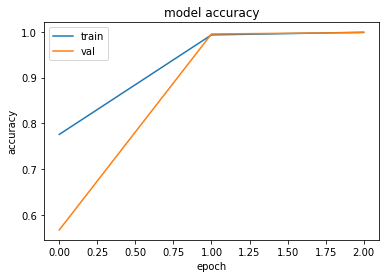

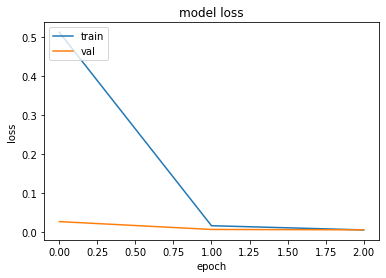

In [ ]:
epochs = 3
root = RESULT_CASIA_DIFFUSION
model_path = os.path.join(model_dir, "2.7_80x80_MiniFASNetV2.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV2.pth")
save_name = os.path.join(model_dir, "2.7_RETRAIN_{}_80x80_MiniFASNetV2".format(dataset_traing))
V2 = True
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 649.32it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 660.59it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 607.30it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 659.07it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 653.37it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 614.92it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 632.79it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 663.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 666.63it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 637.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_10.csv


100%|██████████| 635/635 [00:00<00:00, 748.16it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:00<00:00, 757.63it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:02<00:00, 676.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:02<00:00, 668.12it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 666.04it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [1:18:48<00:00,  2.36s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [1:09:37<00:00,  2.09s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [1:08:58<00:00,  2.07s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [1:04:19<00:00,  1.93s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [56:07<00:00,  1.68s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [59:26<00:00,  1.78s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [59:57<00:00,  1.80s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:03<00:00, 618.59it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 658.18it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [00:02<00:00, 670.04it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [00:02<00:00, 670.07it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:02<00:00, 672.77it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:02<00:00, 670.55it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 636.90it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:03<00:00, 648.98it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:02<00:00, 667.84it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:02<00:00, 668.75it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:03<00:00, 661.85it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:02<00:00, 669.39it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [41:27<00:00,  1.24s/it]


In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_1.csv


100%|██████████| 1999/1999 [00:03<00:00, 605.97it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_2.csv


100%|██████████| 1999/1999 [00:02<00:00, 666.94it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_3.csv


100%|██████████| 1997/1997 [00:03<00:00, 660.41it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_4.csv


100%|██████████| 1999/1999 [00:03<00:00, 651.17it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_5.csv


100%|██████████| 1997/1997 [00:03<00:00, 662.03it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_6.csv


100%|██████████| 1998/1998 [00:02<00:00, 674.51it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_7.csv


100%|██████████| 1999/1999 [00:03<00:00, 653.91it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_8.csv


100%|██████████| 1999/1999 [00:02<00:00, 671.59it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_10.csv


100%|██████████| 1998/1998 [00:03<00:00, 661.47it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_9.csv


100%|██████████| 1995/1995 [00:03<00:00, 662.71it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_11.csv


100%|██████████| 1998/1998 [00:03<00:00, 663.51it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_12.csv


100%|██████████| 1998/1998 [00:03<00:00, 649.10it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 640.82it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_15.csv


100%|██████████| 2000/2000 [00:02<00:00, 668.42it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_14.csv


100%|██████████| 1999/1999 [00:03<00:00, 592.14it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_17.csv


100%|██████████| 1999/1999 [00:02<00:00, 668.76it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_16.csv


100%|██████████| 1997/1997 [00:02<00:00, 681.19it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_0.csv


100%|██████████| 1999/1999 [00:03<00:00, 657.97it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_20.csv


100%|██████████| 40/40 [00:00<00:00, 822.53it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 629.09it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:02<00:00, 669.99it/s]


#### Dataset de SUBSTITUTION

In [ ]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 1380/1380 [03:00<00:00,  7.63it/s]



torch.Size([82536, 3, 80, 80])
torch.Size([82536, 1, 10, 10])
torch.Size([82536])


In [ ]:
dataset_traing = "SUBSTITUTION"
modelo = "SFAS"
epochs = 5

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 350/350 [01:42<00:00,  3.41it/s]


In [ ]:
X_train[0].shape

torch.Size([20999, 3, 80, 80])

In [ ]:
X_train[1].shape

torch.Size([20999, 1, 10, 10])

In [ ]:
y_train.shape

torch.Size([20999])

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [ ]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train[0].shape[0]]

In [ ]:
X_sub_CASIA = X_train_CASIA[0][indices]
X_sub_CASIA.shape

torch.Size([20821, 3, 80, 80])

In [ ]:
X_ft_sub_CASIA = X_train_CASIA[1][indices]
X_ft_sub_CASIA.shape

torch.Size([20821, 1, 10, 10])

In [ ]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

torch.Size([20821])

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [ ]:
X_train_temp = torch.cat((X_train[0], X_sub_CASIA))
X_train_temp.shape

torch.Size([41820, 3, 80, 80])

In [ ]:
X_ft_train = torch.cat((X_train[1], X_ft_sub_CASIA))
X_ft_train.shape

torch.Size([41820, 1, 10, 10])

In [ ]:
y_train_temp = torch.cat((y_train, y_sub_CASIA))
y_train_temp.shape

torch.Size([41820])

In [ ]:
X_train = [X_train_temp, X_ft_train]

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, train_size=0.8, random_state=1234)

In [ ]:
X_ft_train, X_ft_val, y_train, y_val = train_test_split(X_ft_train, y_train_temp, train_size=0.8, random_state=1234)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_ft_train.shape)
print(X_ft_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([33456, 3, 80, 80])
torch.Size([8364, 3, 80, 80])
torch.Size([33456, 1, 10, 10])
torch.Size([8364, 1, 10, 10])
torch.Size([33456])
torch.Size([8364])


Entrenamiento del modelo

In [ ]:
X_train = [X_train, X_ft_train]
X_val = [X_val, X_ft_val]

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  10
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.56it/s]


Loss train 0.32566092274527053 valid 0.10185529072752174
Acc train 0.7913801670074463 valid 0.9259923696517944
epoch 1 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.53it/s]


Loss train 0.09115382089321293 valid 0.08254362789692107
Acc train 0.9353848695755005 valid 0.9372310042381287
epoch 2 started
lr:  [0.1]


100%|██████████| 67/67 [00:19<00:00,  3.52it/s]


Loss train 0.06660948182219889 valid 0.058668279988415506
Acc train 0.9552886486053467 valid 0.9577953219413757
epoch 3 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.53it/s]


Loss train 0.053956514196609386 valid 0.046190697723320455
Acc train 0.9644458889961243 valid 0.9678383469581604
epoch 4 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.53it/s]


Loss train 0.04629368426750845 valid 0.04391290009146159
Acc train 0.9689321517944336 valid 0.9667623043060303
epoch 5 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.54it/s]


Loss train 0.043239233459332095 valid 0.040516049881879276
Acc train 0.9704815149307251 valid 0.9691535234451294
epoch 6 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.53it/s]


Loss train 0.038969731708960745 valid 0.03876272019079553
Acc train 0.9726665019989014 valid 0.9708273410797119
epoch 7 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.54it/s]


Loss train 0.03761002540921987 valid 0.03825953986330986
Acc train 0.973702609539032 valid 0.970588207244873
epoch 8 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.53it/s]


Loss train 0.03635570904545819 valid 0.03935487408002684
Acc train 0.9741744995117188 valid 0.9695122241973877
epoch 9 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.53it/s]


Loss train 0.03354242002007676 valid 0.04624544444497311
Acc train 0.9760127067565918 valid 0.9666427373886108


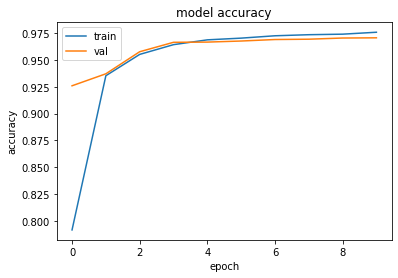

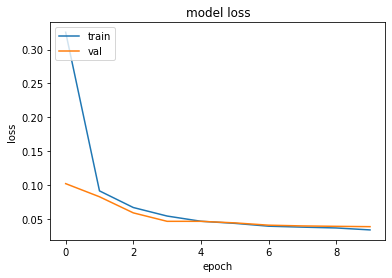

In [ ]:
epochs = 10
root = RESULT_CASIA_SUBSTITUTION
model_path = os.path.join(model_dir, "4_0_0_80x80_MiniFASNetV1SE.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV1SE.pth")
save_name = os.path.join(model_dir, "4_RETRAIN_{}_80x80_MiniFASNetV1SE".format(dataset_traing))
V2 = False
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  10
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 67/67 [00:17<00:00,  3.75it/s]


Loss train 0.3598546465831016 valid 0.13780678809025335
Acc train 0.7085493206977844 valid 0.8872548937797546
epoch 1 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.69it/s]


Loss train 0.10512374719577049 valid 0.07372773176778631
Acc train 0.9218742251396179 valid 0.951339066028595
epoch 2 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


Loss train 0.07172041186201039 valid 0.06214291149824319
Acc train 0.9501813054084778 valid 0.9525346755981445
epoch 3 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


Loss train 0.05381454521817947 valid 0.04232516478652988
Acc train 0.9620321393013 valid 0.9696317315101624
epoch 4 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


Loss train 0.04444575540499011 valid 0.044056741413172826
Acc train 0.968267023563385 valid 0.9702295660972595
epoch 5 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


Loss train 0.04102588155821188 valid 0.04117285399042096
Acc train 0.9718943238258362 valid 0.9679579138755798
epoch 6 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.71it/s]


Loss train 0.03599313443610028 valid 0.04387143406754743
Acc train 0.9740278124809265 valid 0.9681970477104187
epoch 7 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


Loss train 0.03303503562042962 valid 0.03808633298680374
Acc train 0.9761290550231934 valid 0.9717838168144226
epoch 8 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


Loss train 0.030378399903316106 valid 0.040006040976238215
Acc train 0.9782485961914062 valid 0.9681970477104187
epoch 9 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.71it/s]


Loss train 0.02950092797070297 valid 0.03950127443745866
Acc train 0.9782755374908447 valid 0.970349133014679


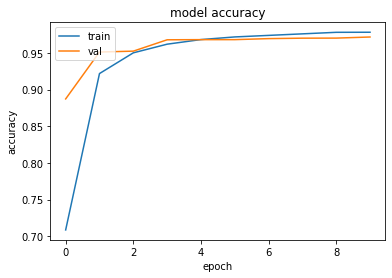

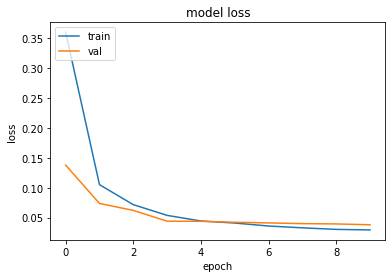

In [ ]:
epochs = 10
root = RESULT_CASIA_SUBSTITUTION
model_path = os.path.join(model_dir, "2.7_80x80_MiniFASNetV2.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV2.pth")
save_name = os.path.join(model_dir, "2.7_RETRAIN_{}_80x80_MiniFASNetV2".format(dataset_traing))
V2 = True
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 525.91it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 542.54it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 535.67it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 538.94it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_10.csv


100%|██████████| 635/635 [00:01<00:00, 612.54it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.49it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.22it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 527.77it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 535.70it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.85it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.90it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:01<00:00, 590.18it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 519.62it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:03<00:00, 550.25it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 535.91it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 514.33it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.37it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 513.48it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [00:05<00:00, 395.73it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:05<00:00, 399.99it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 511.66it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 509.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 501.75it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [00:04<00:00, 481.66it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:03<00:00, 509.84it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:03<00:00, 515.06it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:03<00:00, 514.62it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 511.88it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.98it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 517.40it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [00:03<00:00, 515.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 515.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.69it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [00:03<00:00, 521.89it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 532.04it/s]


In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_0.csv


100%|██████████| 1999/1999 [00:03<00:00, 511.11it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_5.csv


100%|██████████| 1997/1997 [00:04<00:00, 494.29it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_3.csv


100%|██████████| 1997/1997 [00:03<00:00, 518.31it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 519.53it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_4.csv


100%|██████████| 1999/1999 [00:03<00:00, 512.14it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_10.csv


100%|██████████| 1998/1998 [00:03<00:00, 510.53it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_6.csv


100%|██████████| 1998/1998 [00:03<00:00, 517.33it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_8.csv


100%|██████████| 1999/1999 [00:03<00:00, 515.97it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_9.csv


100%|██████████| 1995/1995 [00:03<00:00, 527.39it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_11.csv


100%|██████████| 1998/1998 [00:03<00:00, 514.56it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_12.csv


100%|██████████| 1998/1998 [00:03<00:00, 516.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_14.csv


100%|██████████| 1999/1999 [00:03<00:00, 517.14it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 520.48it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_16.csv


100%|██████████| 1997/1997 [00:03<00:00, 520.62it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_17.csv


100%|██████████| 1999/1999 [00:03<00:00, 513.81it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:03<00:00, 517.52it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_20.csv


100%|██████████| 40/40 [00:00<00:00, 696.03it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 509.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_1.csv


100%|██████████| 1999/1999 [00:03<00:00, 512.99it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_2.csv


100%|██████████| 1999/1999 [00:03<00:00, 507.05it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_7.csv


100%|██████████| 1999/1999 [00:03<00:00, 507.27it/s]


#### Dataset de CASIA

In [ ]:
dataset_traing = "CASIA"
modelo = "SFAS"
epochs = 5

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 1380/1380 [03:01<00:00,  7.59it/s]


In [ ]:
X_train[0].shape

torch.Size([82536, 3, 80, 80])

In [ ]:
X_train[1].shape

torch.Size([82536, 1, 10, 10])

In [ ]:
y_train.shape

torch.Size([82536])

In [ ]:
X_train_temp = X_train[0]
X_train_temp.shape

torch.Size([82536, 3, 80, 80])

In [ ]:
X_ft_train = X_train[1]
X_ft_train.shape

torch.Size([82536, 1, 10, 10])

In [ ]:
y_train_temp = y_train
y_train_temp.shape

torch.Size([82536])

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train, train_size=0.8, random_state=1234)

In [ ]:
X_ft_train, X_ft_val, y_train, y_val = train_test_split(X_ft_train, y_train_temp, train_size=0.8, random_state=1234)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_ft_train.shape)
print(X_ft_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([66028, 3, 80, 80])
torch.Size([16508, 3, 80, 80])
torch.Size([66028, 1, 10, 10])
torch.Size([16508, 1, 10, 10])
torch.Size([66028])
torch.Size([16508])


Entrenamiento del modelo

In [ ]:
X_train = [X_train, X_ft_train]
X_val = [X_val, X_ft_val]

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  4
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 133/133 [09:17<00:00,  4.19s/it]


Loss train 0.19177396673905223 valid 0.04899811056799142
Acc train 0.8985564112663269 valid 0.9782529473304749
epoch 1 started
lr:  [0.1]


100%|██████████| 133/133 [09:13<00:00,  4.16s/it]


Loss train 0.028145337883467066 valid 0.02655455960781749
Acc train 0.9828892946243286 valid 0.9823721647262573
epoch 2 started
lr:  [0.1]


100%|██████████| 133/133 [09:15<00:00,  4.18s/it]


Loss train 0.02000493020925643 valid 0.016365851092621904
Acc train 0.987835168838501 valid 0.991095244884491
epoch 3 started
lr:  [0.1]


100%|██████████| 133/133 [09:19<00:00,  4.21s/it]


Loss train 0.007104773228441863 valid 0.01055838782691834
Acc train 0.9968875646591187 valid 0.9938817620277405


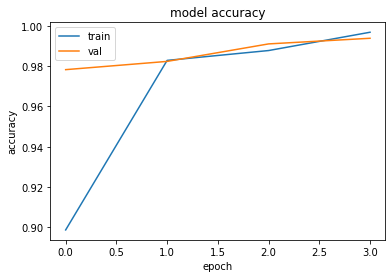

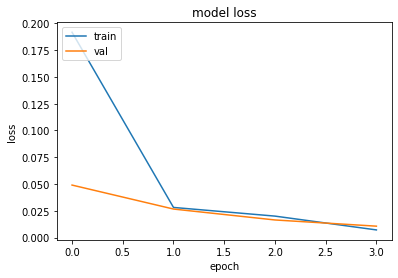

In [ ]:
epochs = 4
root = RESULT_CASIA
model_path = os.path.join(model_dir, "4_0_0_80x80_MiniFASNetV1SE.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV1SE.pth")
save_name = os.path.join(model_dir, "4_RETRAIN_{}_80x80_MiniFASNetV1SE".format(dataset_traing))
V2 = False
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  4
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 133/133 [09:03<00:00,  4.09s/it]


Loss train 0.17323309737712816 valid 0.03148329283022309
Acc train 0.9113104939460754 valid 0.9846135377883911
epoch 1 started
lr:  [0.1]


100%|██████████| 133/133 [09:04<00:00,  4.09s/it]


Loss train 0.027159901945046465 valid 0.015340415272543685
Acc train 0.9862406849861145 valid 0.9924885034561157
epoch 2 started
lr:  [0.1]


100%|██████████| 133/133 [09:08<00:00,  4.12s/it]


Loss train 0.010095238251457537 valid 0.029119745351160378
Acc train 0.9964967966079712 valid 0.9915192723274231
epoch 3 started
lr:  [0.1]


100%|██████████| 133/133 [09:03<00:00,  4.09s/it]


Loss train 0.0098041649802791 valid 0.014231086730289423
Acc train 0.9960907697677612 valid 0.9948509931564331


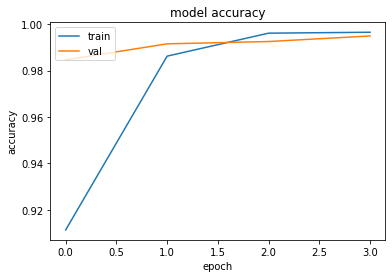

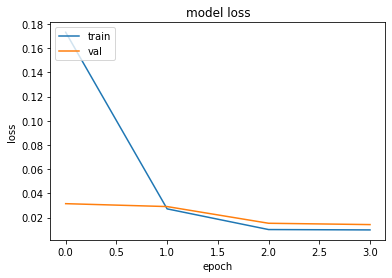

In [ ]:
epochs = 4
root = RESULT_CASIA
model_path = os.path.join(model_dir, "2.7_80x80_MiniFASNetV2.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV2.pth")
save_name = os.path.join(model_dir, "2.7_RETRAIN_{}_80x80_MiniFASNetV2".format(dataset_traing))
V2 = True
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_0.csv


100%|██████████| 2000/2000 [31:02<00:00,  1.07it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_1.csv


100%|██████████| 2000/2000 [29:11<00:00,  1.14it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_2.csv


100%|██████████| 2000/2000 [29:29<00:00,  1.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_3.csv


100%|██████████| 2000/2000 [29:31<00:00,  1.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_4.csv


100%|██████████| 2000/2000 [29:43<00:00,  1.12it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_5.csv


100%|██████████| 2000/2000 [30:05<00:00,  1.11it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_6.csv


100%|██████████| 2000/2000 [30:21<00:00,  1.10it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_7.csv


100%|██████████| 2000/2000 [30:10<00:00,  1.10it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_8.csv


100%|██████████| 2000/2000 [29:54<00:00,  1.11it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_9.csv


100%|██████████| 2000/2000 [29:57<00:00,  1.11it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_10.csv


100%|██████████| 635/635 [09:27<00:00,  1.12it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [25:20<00:00,  1.10it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [29:33<00:00,  1.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_3.csv


100%|██████████| 694/694 [10:18<00:00,  1.12it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [29:43<00:00,  1.12it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, True, False, False)

In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:03<00:00, 586.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_19.csv


 66%|██████▌   | 1323/2000 [00:02<00:01, 560.41it/s]

#### Dataset de StyleGAN

In [ ]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 1380/1380 [02:25<00:00,  9.46it/s]



torch.Size([82536, 3, 80, 80])
torch.Size([82536, 1, 10, 10])
torch.Size([82536])


In [ ]:
dataset_traing = "StyleGAN"
modelo = "SFAS"
epochs = 5

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 210/210 [00:42<00:00,  4.91it/s]


In [ ]:
X_train[0].shape

torch.Size([20984, 3, 80, 80])

In [ ]:
X_train[1].shape

torch.Size([20984, 1, 10, 10])

In [ ]:
y_train.shape

torch.Size([20984])

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [ ]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train[0].shape[0]]

In [ ]:
X_sub_CASIA = X_train_CASIA[0][indices]
X_sub_CASIA.shape

torch.Size([20821, 3, 80, 80])

In [ ]:
X_ft_sub_CASIA = X_train_CASIA[1][indices]
X_ft_sub_CASIA.shape

torch.Size([20821, 1, 10, 10])

In [ ]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

torch.Size([20821])

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [ ]:
X_train_temp = torch.cat((X_train[0], X_sub_CASIA))
X_train_temp.shape

torch.Size([41805, 3, 80, 80])

In [ ]:
X_ft_train = torch.cat((X_train[1], X_ft_sub_CASIA))
X_ft_train.shape

torch.Size([41805, 1, 10, 10])

In [ ]:
y_train_temp = torch.cat((y_train, y_sub_CASIA))
y_train_temp.shape

torch.Size([41805])

In [ ]:
X_train = [X_train_temp, X_ft_train]

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, train_size=0.8, random_state=1234)

In [ ]:
X_ft_train, X_ft_val, y_train, y_val = train_test_split(X_ft_train, y_train_temp, train_size=0.8, random_state=1234)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_ft_train.shape)
print(X_ft_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([33444, 3, 80, 80])
torch.Size([8361, 3, 80, 80])
torch.Size([33444, 1, 10, 10])
torch.Size([8361, 1, 10, 10])
torch.Size([33444])
torch.Size([8361])


Entrenamiento del modelo

In [ ]:
X_train = [X_train, X_ft_train]
X_val = [X_val, X_ft_val]

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  4
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 67/67 [00:25<00:00,  2.67it/s]


Loss train 0.17853419908058288 valid 0.010386270475857091
Acc train 0.9274923801422119 valid 0.9955747127532959
epoch 1 started
lr:  [0.1]


100%|██████████| 67/67 [00:17<00:00,  3.76it/s]


Loss train 0.007919768260708495 valid 0.006006654755967745
Acc train 0.9965596795082092 valid 0.9980863332748413
epoch 2 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.68it/s]


Loss train 0.003927814558759999 valid 0.004065484141695715
Acc train 0.9991641640663147 valid 0.9991627931594849
epoch 3 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.61it/s]


Loss train 0.002693909814636876 valid 0.003315599385307169
Acc train 0.9999103546142578 valid 0.9991627931594849


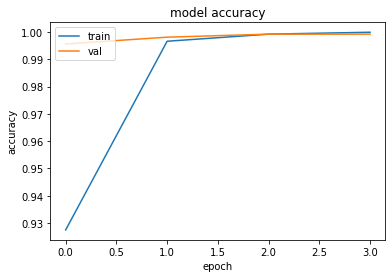

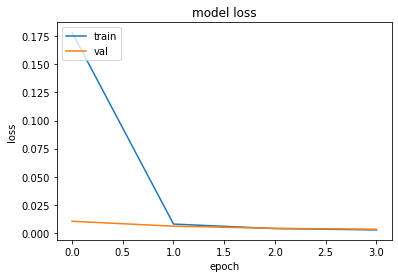

In [ ]:
epochs = 4
root = RESULT_StyleGAN
model_path = os.path.join(model_dir, "4_0_0_80x80_MiniFASNetV1SE.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV1SE.pth")
save_name = os.path.join(model_dir, "4_RETRAIN_{}_80x80_MiniFASNetV1SE".format(dataset_traing))
V2 = False
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  3
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.64it/s]


Loss train 0.24197901515707151 valid 0.02352918430216061
Acc train 0.8741306066513062 valid 0.9848104119300842
epoch 1 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.66it/s]


Loss train 0.014202264200117606 valid 0.010620526244848943
Acc train 0.9920744299888611 valid 0.9955747127532959
epoch 2 started
lr:  [0.1]


100%|██████████| 67/67 [00:18<00:00,  3.65it/s]


Loss train 0.00667854452352804 valid 0.010335763909856832
Acc train 0.9975108504295349 valid 0.9961727261543274


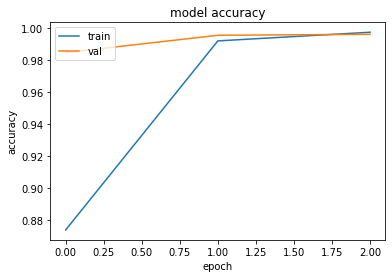

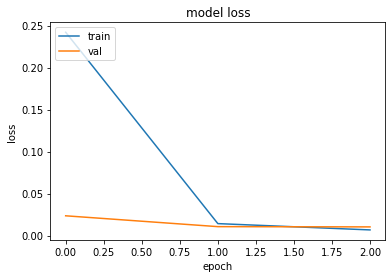

In [ ]:
epochs = 3
root = RESULT_StyleGAN
model_path = os.path.join(model_dir, "2.7_80x80_MiniFASNetV2.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV2.pth")
save_name = os.path.join(model_dir, "2.7_RETRAIN_{}_80x80_MiniFASNetV2".format(dataset_traing))
V2 = True
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 649.48it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 664.18it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 634.20it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 642.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 661.74it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 648.69it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 647.15it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 650.77it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 642.32it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_10.csv


100%|██████████| 635/635 [00:00<00:00, 726.20it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 659.64it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:02<00:00, 685.89it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 657.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 657.46it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:00<00:00, 742.37it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [1:31:31<00:00,  2.75s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [1:17:38<00:00,  2.33s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 650.83it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 645.19it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [00:02<00:00, 674.79it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 634.03it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 658.02it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 648.92it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 663.64it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 638.11it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 631.08it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 651.26it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:02<00:00, 672.00it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:03<00:00, 662.06it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:03<00:00, 639.10it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 638.77it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:03<00:00, 655.41it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 649.69it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [00:03<00:00, 643.99it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [30:50<00:00,  1.08it/s]


In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_1.csv


100%|██████████| 1999/1999 [1:03:45<00:00,  1.91s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_2.csv


100%|██████████| 1999/1999 [1:05:11<00:00,  1.96s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_3.csv


100%|██████████| 1997/1997 [1:06:36<00:00,  2.00s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_4.csv


100%|██████████| 1999/1999 [1:05:18<00:00,  1.96s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_5.csv


100%|██████████| 1997/1997 [1:04:36<00:00,  1.94s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_6.csv


100%|██████████| 1998/1998 [1:05:20<00:00,  1.96s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_7.csv


100%|██████████| 1999/1999 [1:05:26<00:00,  1.96s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_8.csv


100%|██████████| 1999/1999 [1:03:17<00:00,  1.90s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_9.csv


100%|██████████| 1995/1995 [1:02:58<00:00,  1.89s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_10.csv


100%|██████████| 1998/1998 [1:04:44<00:00,  1.94s/it]


#### Todos los Dataset

In [92]:
modelo = "SFAS"

In [93]:
dataset_traing = "DIFFUSION"
X_train_DIFFUSION, y_train_DIFFUSION = get_files(dataset_traing, modelo)

100%|██████████| 115/115 [00:00<00:00, 328.89it/s]


In [94]:
dataset_traing = "SUBSTITUTION"
X_train_SUBSTITUTION, y_train_SUBSTITUTION = get_files(dataset_traing, modelo)

100%|██████████| 350/350 [00:09<00:00, 35.38it/s]


In [95]:
dataset_traing = "CASIA"
X_train_CASIA, y_train_CASIA = get_files(dataset_traing, modelo)

100%|██████████| 1380/1380 [00:12<00:00, 112.44it/s]


In [96]:
dataset_traing = "StyleGAN"
X_train_StyleGAN, y_train_StyleGAN = get_files(dataset_traing, modelo)

100%|██████████| 210/210 [00:08<00:00, 23.53it/s]


In [97]:
print(X_train_DIFFUSION[0].shape)
print(X_train_DIFFUSION[1].shape)
print(y_train_DIFFUSION.shape)
print(X_train_CASIA[0].shape)
print(X_train_CASIA[1].shape)
print(y_train_CASIA.shape)
print(X_train_StyleGAN[0].shape)
print(X_train_StyleGAN[1].shape)
print(y_train_StyleGAN.shape)
print(X_train_SUBSTITUTION[0].shape)
print(X_train_SUBSTITUTION[1].shape)
print(y_train_SUBSTITUTION.shape)

torch.Size([6694, 3, 80, 80])
torch.Size([6694, 1, 10, 10])
torch.Size([6694])
torch.Size([82536, 3, 80, 80])
torch.Size([82536, 1, 10, 10])
torch.Size([82536])
torch.Size([20984, 3, 80, 80])
torch.Size([20984, 1, 10, 10])
torch.Size([20984])
torch.Size([20999, 3, 80, 80])
torch.Size([20999, 1, 10, 10])
torch.Size([20999])


concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [98]:
X_train_temp = torch.cat((X_train_DIFFUSION[0], X_train_CASIA[0]))
X_ft_train_temp = torch.cat((X_train_DIFFUSION[1], X_train_CASIA[1]))
y_train_temp = torch.cat((y_train_DIFFUSION, y_train_CASIA))

In [99]:
X_train_temp = torch.cat((X_train_temp, X_train_StyleGAN[0]))
X_ft_train_temp = torch.cat((X_ft_train_temp, X_train_StyleGAN[1]))
y_train_temp = torch.cat((y_train_temp, y_train_StyleGAN))

In [100]:
X_train_temp = torch.cat((X_train_temp, X_train_SUBSTITUTION[0]))
X_ft_train_temp = torch.cat((X_ft_train_temp, X_train_SUBSTITUTION[1]))
y_train_temp = torch.cat((y_train_temp, y_train_SUBSTITUTION))

Datasets de validación

In [101]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, train_size=0.8, random_state=1234)

In [102]:
X_ft_train, X_ft_val, y_train, y_val = train_test_split(X_ft_train_temp, y_train_temp, train_size=0.8, random_state=1234)

In [103]:
print(X_train.shape)
print(X_val.shape)
print(X_ft_train.shape)
print(X_ft_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([104970, 3, 80, 80])
torch.Size([26243, 3, 80, 80])
torch.Size([104970, 1, 10, 10])
torch.Size([26243, 1, 10, 10])
torch.Size([104970])
torch.Size([26243])


Entrenamiento del modelo

In [104]:
X_train = [X_train, X_ft_train]
X_val = [X_val, X_ft_val]

In [105]:
dataset_traing = "ALL"

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  20
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 210/210 [01:03<00:00,  3.32it/s]


Loss train 0.17723139859735965 valid 0.053763282187379156
Acc train 0.900956392288208 valid 0.9625424146652222
epoch 1 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.46it/s]


Loss train 0.04067454565139044 valid 0.03035975295512753
Acc train 0.9720732569694519 valid 0.9814807772636414
epoch 2 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.028140473858054196 valid 0.025821780402217376
Acc train 0.9817669987678528 valid 0.9849483966827393
epoch 3 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.023856157507924806 valid 0.023429571352368343
Acc train 0.9854936003684998 valid 0.9852151274681091
epoch 4 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.02071247020115455 valid 0.020922002924208295
Acc train 0.9868366718292236 valid 0.9868536591529846
epoch 5 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.018195625789286126 valid 0.021073257216835253
Acc train 0.9881775975227356 valid 0.9861677289009094
epoch 6 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.01717272791346269 valid 0.022591314397748665
Acc train 0.9885395765304565 valid 0.9853294491767883
epoch 7 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.46it/s]


Loss train 0.01666160500386641 valid 0.017022832580228638
Acc train 0.9887984991073608 valid 0.9890256524085999
epoch 8 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.46it/s]


Loss train 0.016339665522710198 valid 0.017849598568165058
Acc train 0.9889890551567078 valid 0.9886826872825623
epoch 9 started
lr:  [0.1]


100%|██████████| 210/210 [01:00<00:00,  3.46it/s]


Loss train 0.01577318049967289 valid 0.01854777051914513
Acc train 0.9896748661994934 valid 0.9876919388771057
epoch 10 started
lr:  [0.010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.010205487892519505 valid 0.011975819255985485
Acc train 0.9931809306144714 valid 0.9916930198669434
epoch 11 started
lr:  [0.010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.008115510291065133 valid 0.012130853252833156
Acc train 0.9945321679115295 valid 0.9916549324989319
epoch 12 started
lr:  [0.010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.007409720915547084 valid 0.011827972001861625
Acc train 0.9951236248016357 valid 0.9916167855262756
epoch 13 started
lr:  [0.010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.006669825640884006 valid 0.012099976751735917
Acc train 0.9954761862754822 valid 0.9917311072349548
epoch 14 started
lr:  [0.010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.006135817300084801 valid 0.012093924299869841
Acc train 0.9960564374923706 valid 0.9917692542076111
epoch 15 started
lr:  [0.0010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.005496548620673517 valid 0.01223626382466741
Acc train 0.9966945052146912 valid 0.9916930198669434
epoch 16 started
lr:  [0.0010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.005279328966779368 valid 0.011979646635508321
Acc train 0.9969611167907715 valid 0.9918073415756226
epoch 17 started
lr:  [0.0010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.005275280323500434 valid 0.012027349906386358
Acc train 0.9969431757926941 valid 0.9918073415756226
epoch 18 started
lr:  [0.0010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.45it/s]


Loss train 0.005196826258629915 valid 0.012266845197709686
Acc train 0.9968659281730652 valid 0.991845428943634
epoch 19 started
lr:  [0.0010000000000000002]


100%|██████████| 210/210 [01:00<00:00,  3.46it/s]


Loss train 0.005071732097504927 valid 0.012169972113686594
Acc train 0.997056782245636 valid 0.991845428943634


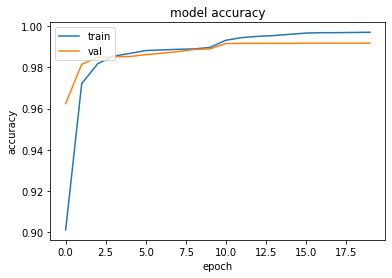

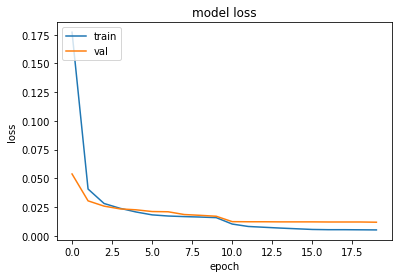

In [ ]:
epochs = 20
root = RESULT_StyleGAN
model_path = os.path.join(model_dir, "4_0_0_80x80_MiniFASNetV1SE.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV1SE.pth")
save_name = os.path.join(model_dir, "4_RETRAIN_{}_80x80_MiniFASNetV1SE".format(dataset_traing))
V2 = False
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

------------------------- Pesos cargando
------------------------- Pesos cargados
lr:  0.1
epochs:  5
milestones:  [10, 15, 22]
epoch 0 started
lr:  [0.1]


100%|██████████| 210/210 [00:58<00:00,  3.56it/s]


Loss train 0.1298099068569995 valid 0.0321837761296775
Acc train 0.9331617951393127 valid 0.9782037138938904
epoch 1 started
lr:  [0.1]


100%|██████████| 210/210 [00:59<00:00,  3.54it/s]


Loss train 0.027181166543492247 valid 0.022564092723097125
Acc train 0.9816069006919861 valid 0.9854056239128113
epoch 2 started
lr:  [0.1]


100%|██████████| 210/210 [00:59<00:00,  3.53it/s]


Loss train 0.02077663555031731 valid 0.022089920279963482
Acc train 0.9867885708808899 valid 0.9848340749740601
epoch 3 started
lr:  [0.1]


100%|██████████| 210/210 [00:59<00:00,  3.53it/s]


Loss train 0.017926981810125565 valid 0.02311570753051884
Acc train 0.9879494309425354 valid 0.9834241271018982
epoch 4 started
lr:  [0.1]


100%|██████████| 210/210 [00:59<00:00,  3.53it/s]


Loss train 0.016114148016398152 valid 0.020496375500505048
Acc train 0.9890538454055786 valid 0.9857866764068604


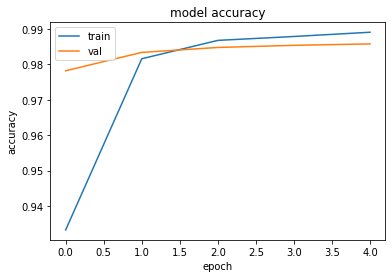

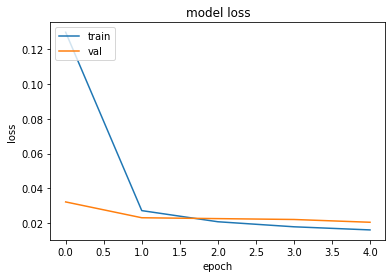

In [ ]:
epochs = 5
root = RESULT_StyleGAN
model_path = os.path.join(model_dir, "2.7_80x80_MiniFASNetV2.pth")
model_path_FT = os.path.join(model_dir, "FTGenerator_MiniFASNetV2.pth")
save_name = os.path.join(model_dir, "2.7_RETRAIN_{}_80x80_MiniFASNetV2".format(dataset_traing))
V2 = True
clf = entrenamiento_modelo_SFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:02<00:00, 679.59it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:02<00:00, 675.85it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:02<00:00, 677.15it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 630.26it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 666.17it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:02<00:00, 676.39it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:02<00:00, 682.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:02<00:00, 671.05it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:02<00:00, 673.95it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_10.csv


100%|██████████| 635/635 [00:00<00:00, 758.21it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 601.21it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:02<00:00, 684.43it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:02<00:00, 677.06it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:00<00:00, 754.96it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:02<00:00, 688.97it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, True, False, False)

In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, True, False, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_11.csv


100%|██████████| 1998/1998 [1:02:38<00:00,  1.88s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_12.csv


100%|██████████| 1998/1998 [1:10:07<00:00,  2.11s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_14.csv


100%|██████████| 1999/1999 [1:11:06<00:00,  2.13s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_13.csv


100%|██████████| 2000/2000 [1:10:17<00:00,  2.11s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_20.csv


100%|██████████| 40/40 [01:29<00:00,  2.23s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_16.csv


100%|██████████| 1997/1997 [1:11:32<00:00,  2.15s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_15.csv


100%|██████████| 2000/2000 [1:10:23<00:00,  2.11s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_17.csv


100%|██████████| 1999/1999 [1:12:00<00:00,  2.16s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_19.csv


100%|██████████| 2000/2000 [1:15:30<00:00,  2.27s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_18.csv


100%|██████████| 1993/1993 [1:14:36<00:00,  2.25s/it]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_0.csv


100%|██████████| 1999/1999 [1:16:49<00:00,  2.31s/it]


## Algoritmo Detection Liveness FAS

### Entrenamiento del modelo

In [106]:
def entrenamiento_modelo_LDFAS(X_train, y_train, X_val, y_val):
    liveness_model = tf.keras.models.load_model(args['model'])
    
    # Entrenamiento de modelo temporal
    liveness_model_temp = liveness_model

    history = liveness_model_temp.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Guardar modelo
    # Guardar el Modelo
    model_path = BASE_FLDAS + "liveness_{}.model".format(dataset_traing)
    liveness_model_temp.save(model_path)

    return liveness_model_temp

### Lectura de archivos de pruebas para ser clasificados

In [107]:
def get_data_CASIA():
    X_train_CASIA, y_train_CASIA = get_files("CASIA", "LDFAS")
    print(X_train_CASIA.shape)
    print(y_train_CASIA.shape)
    return X_train_CASIA, y_train_CASIA

#### Dataset de DIFFUSION

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [ ]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 552/552 [02:16<00:00,  4.05it/s]


(82260, 3072)
(82260, 2)


In [ ]:
dataset_traing = "DIFFUSION"
modelo = "LDFAS"
epochs = 40

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 46/46 [00:21<00:00,  2.15it/s]


In [ ]:
X_train.shape

(6671, 3072)

In [ ]:
y_train.shape

(6671, 2)

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [ ]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train.shape[0]]

In [ ]:
X_sub_CASIA = X_train_CASIA[indices]
X_sub_CASIA.shape

(6671, 3072)

In [ ]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

(6671, 2)

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [ ]:
X_train = np.concatenate((X_train, X_sub_CASIA))
X_train.shape

(13342, 3072)

In [ ]:
X = np.zeros((X_train.shape[0], 32, 32, 3), dtype=np.float)
count = 0
for row in tqdm(X_train):
    X[count] = row.reshape(32, 32, 3)
    count += 1

X_train = X
X_train.shape

100%|██████████| 13342/13342 [00:00<00:00, 39927.45it/s]


(13342, 32, 32, 3)

In [ ]:
y_train = np.concatenate((y_train, y_sub_CASIA))
y_train.shape

(13342, 2)

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(10673, 32, 32, 3)
(2669, 32, 32, 3)
(10673, 2)
(2669, 2)


Entrenamiento del modelo

Epoch 1/40
334/334 [==============================] - 15s 44ms/step - loss: 0.7390 - accuracy: 0.6342 - val_loss: 1.1166 - val_accuracy: 0.2896
Epoch 2/40
334/334 [==============================] - 15s 44ms/step - loss: 0.5094 - accuracy: 0.7756 - val_loss: 0.6272 - val_accuracy: 0.6583
Epoch 3/40
334/334 [==============================] - 15s 44ms/step - loss: 0.3967 - accuracy: 0.8568 - val_loss: 0.4481 - val_accuracy: 0.8535
Epoch 4/40
334/334 [==============================] - 14s 43ms/step - loss: 0.3043 - accuracy: 0.9108 - val_loss: 0.3184 - val_accuracy: 0.9052
Epoch 5/40
334/334 [==============================] - 15s 43ms/step - loss: 0.2315 - accuracy: 0.9425 - val_loss: 0.2056 - val_accuracy: 0.9798
Epoch 6/40
334/334 [==============================] - 14s 43ms/step - loss: 0.1767 - accuracy: 0.9616 - val_loss: 0.1691 - val_accuracy: 0.9723
Epoch 7/40
334/334 [==============================] - 15s 44ms/step - loss: 0.1410 - accuracy: 0.9693 - val_loss: 0.1233 - val_accuracy:

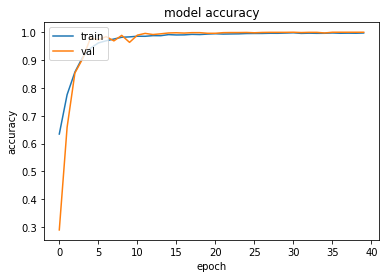

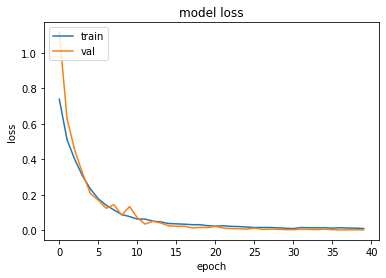

In [ ]:
liveness_model = entrenamiento_modelo_LDFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
dataset_traing = "DIFFUSION"
model_path = BASE_FLDAS + "liveness_{}.model".format(dataset_traing)
liveness_model = tf.keras.models.load_model(model_path)

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 519.38it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 540.38it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.98it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 516.16it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.84it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 534.31it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.99it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 532.00it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_10.csv


100%|██████████| 635/635 [00:01<00:00, 585.19it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 538.56it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 532.55it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:01<00:00, 610.20it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 552.98it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:02<00:00, 560.64it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 546.41it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 533.39it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 530.07it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 519.34it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.35it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 535.22it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.17it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 535.06it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.52it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [00:03<00:00, 537.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.49it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.87it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.39it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:03<00:00, 517.18it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 527.99it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.34it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.18it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.71it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [00:03<00:00, 527.20it/s]


In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_2.csv


100%|██████████| 1999/1999 [00:03<00:00, 526.53it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_1.csv


100%|██████████| 1999/1999 [00:03<00:00, 523.70it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_3.csv


100%|██████████| 1997/1997 [00:04<00:00, 461.99it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_4.csv


100%|██████████| 1999/1999 [00:03<00:00, 529.00it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_5.csv


100%|██████████| 1997/1997 [00:03<00:00, 531.33it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_7.csv


100%|██████████| 1999/1999 [00:03<00:00, 534.75it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_6.csv


100%|██████████| 1998/1998 [00:03<00:00, 535.50it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_8.csv


100%|██████████| 1999/1999 [00:03<00:00, 519.73it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_10.csv


100%|██████████| 1998/1998 [00:03<00:00, 514.88it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_9.csv


100%|██████████| 1995/1995 [00:03<00:00, 521.58it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_11.csv


100%|██████████| 1998/1998 [00:03<00:00, 524.73it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_12.csv


100%|██████████| 1998/1998 [00:03<00:00, 524.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.31it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.35it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_14.csv


100%|██████████| 1999/1999 [00:03<00:00, 521.63it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_17.csv


100%|██████████| 1999/1999 [00:03<00:00, 532.49it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_16.csv


100%|██████████| 1997/1997 [00:03<00:00, 529.31it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_20.csv


100%|██████████| 40/40 [00:00<00:00, 722.43it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_0.csv


100%|██████████| 1999/1999 [00:03<00:00, 527.64it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.77it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:03<00:00, 525.82it/s]


#### Dataset de SUBSTITUTION

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [ ]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 552/552 [01:53<00:00,  4.86it/s]


(82260, 3072)
(82260, 2)


In [ ]:
dataset_traing = "SUBSTITUTION"
modelo = "LDFAS"
epochs = 40

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 140/140 [00:31<00:00,  4.43it/s]


In [ ]:
X_train.shape

(20929, 3072)

In [ ]:
y_train = y_train[:X_train.shape[0]]
if X_train.shape[0] > y_train.shape[0]:
    X_train = X_train[:y_train.shape[0]]
y_train.shape

(20929, 2)

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [ ]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train.shape[0]]

In [ ]:
X_sub_CASIA = X_train_CASIA[indices]
X_sub_CASIA.shape

(20929, 3072)

In [ ]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

(20929, 2)

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [ ]:
X_train = np.concatenate((X_train, X_sub_CASIA))
X_train.shape

(41858, 3072)

In [ ]:
X = np.zeros((X_train.shape[0], 32, 32, 3), dtype=np.float)
count = 0
for row in tqdm(X_train):
    X[count] = row.reshape(32, 32, 3)
    count += 1

X_train = X
X_train.shape

100%|██████████| 41858/41858 [00:00<00:00, 96813.60it/s]


(41858, 32, 32, 3)

In [ ]:
y_train = np.concatenate((y_train, y_sub_CASIA))
y_train.shape

(41858, 2)

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(33486, 32, 32, 3)
(8372, 32, 32, 3)
(33486, 2)
(8372, 2)


Entrenamiento del modelo

Epoch 1/40
1047/1047 [==============================] - 52s 49ms/step - loss: 0.5834 - accuracy: 0.7395 - val_loss: 0.4718 - val_accuracy: 0.8452
Epoch 2/40
1047/1047 [==============================] - 52s 49ms/step - loss: 0.3064 - accuracy: 0.8998 - val_loss: 0.2754 - val_accuracy: 0.9244
Epoch 3/40
1047/1047 [==============================] - 50s 48ms/step - loss: 0.1969 - accuracy: 0.9334 - val_loss: 0.2122 - val_accuracy: 0.9371
Epoch 4/40
1047/1047 [==============================] - 50s 48ms/step - loss: 0.1399 - accuracy: 0.9519 - val_loss: 0.1178 - val_accuracy: 0.9619
Epoch 5/40
1047/1047 [==============================] - 50s 48ms/step - loss: 0.1129 - accuracy: 0.9597 - val_loss: 0.1149 - val_accuracy: 0.9627
Epoch 6/40
1047/1047 [==============================] - 50s 48ms/step - loss: 0.0962 - accuracy: 0.9659 - val_loss: 0.0884 - val_accuracy: 0.9742
Epoch 7/40
1047/1047 [==============================] - 49s 47ms/step - loss: 0.0857 - accuracy: 0.9693 - val_loss: 0.0597 -

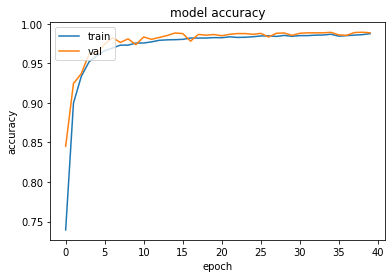

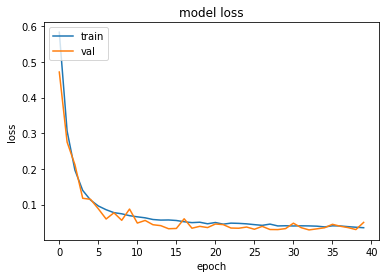

In [ ]:
liveness_model = entrenamiento_modelo_LDFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
dataset_traing = "SUBSTITUTION"
model_path = BASE_FLDAS + "liveness_{}.model".format(dataset_traing)
liveness_model = tf.keras.models.load_model(model_path)

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 503.40it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:04<00:00, 475.87it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:04<00:00, 494.00it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:04<00:00, 493.66it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_10.csv


100%|██████████| 635/635 [00:01<00:00, 573.67it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:05<00:00, 392.61it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:04<00:00, 416.46it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 501.89it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.24it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.66it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.05it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:01<00:00, 617.28it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 538.70it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:03<00:00, 555.67it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 535.86it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 520.24it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 524.02it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.28it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 519.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 516.46it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 516.93it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.24it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 527.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 517.28it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:03<00:00, 524.77it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:03<00:00, 520.61it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.84it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 520.02it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.59it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:03<00:00, 516.42it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [00:03<00:00, 516.39it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [00:03<00:00, 520.71it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [00:03<00:00, 516.87it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 519.92it/s]


In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_17.csv


100%|██████████| 1999/1999 [00:03<00:00, 521.70it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:03<00:00, 523.78it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.62it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_20.csv


100%|██████████| 40/40 [00:00<00:00, 669.12it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_1.csv


100%|██████████| 1999/1999 [00:03<00:00, 518.95it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_2.csv


100%|██████████| 1999/1999 [00:03<00:00, 526.00it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_7.csv


100%|██████████| 1999/1999 [00:03<00:00, 514.39it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_5.csv


100%|██████████| 1997/1997 [00:03<00:00, 502.17it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_0.csv


100%|██████████| 1999/1999 [00:03<00:00, 519.94it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_3.csv


100%|██████████| 1997/1997 [00:03<00:00, 525.19it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 519.64it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_10.csv


100%|██████████| 1998/1998 [00:03<00:00, 526.21it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_4.csv


100%|██████████| 1999/1999 [00:03<00:00, 524.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_8.csv


100%|██████████| 1999/1999 [00:03<00:00, 519.43it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_6.csv


100%|██████████| 1998/1998 [00:03<00:00, 512.66it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_9.csv


100%|██████████| 1995/1995 [00:03<00:00, 522.20it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_11.csv


100%|██████████| 1998/1998 [00:03<00:00, 527.30it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_12.csv


100%|██████████| 1998/1998 [00:03<00:00, 521.11it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_14.csv


100%|██████████| 1999/1999 [00:03<00:00, 522.06it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_16.csv


100%|██████████| 1997/1997 [00:03<00:00, 529.25it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 514.36it/s]


#### Dataset de CASIA

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [ ]:
dataset_traing = "CASIA"
modelo = "LDFAS"
epochs = 40

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 552/552 [02:19<00:00,  3.94it/s]


In [ ]:
X_train.shape

(82260, 3072)

In [ ]:
y_train = y_train[:X_train.shape[0]]
y_train.shape

(82260, 2)

In [ ]:
X = np.zeros((X_train.shape[0], 32, 32, 3), dtype=np.float)
count = 0
for row in tqdm(X_train):
    X[count] = row.reshape(32, 32, 3)
    count += 1

X_train = X
X_train.shape

100%|██████████| 82260/82260 [00:00<00:00, 87599.13it/s]


(82260, 32, 32, 3)

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(65808, 32, 32, 3)
(16452, 32, 32, 3)
(65808, 2)
(16452, 2)


Entrenamiento del modelo

Epoch 1/40
2057/2057 [==============================] - 95s 46ms/step - loss: 0.2634 - accuracy: 0.9088 - val_loss: 0.1388 - val_accuracy: 0.9740
Epoch 2/40
2057/2057 [==============================] - 95s 46ms/step - loss: 0.0597 - accuracy: 0.9854 - val_loss: 0.0167 - val_accuracy: 0.9972
Epoch 3/40
2057/2057 [==============================] - 94s 46ms/step - loss: 0.0246 - accuracy: 0.9931 - val_loss: 0.0049 - val_accuracy: 0.9980
Epoch 4/40
2057/2057 [==============================] - 93s 45ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0019 - val_accuracy: 0.9980
Epoch 5/40
2057/2057 [==============================] - 95s 46ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0020 - val_accuracy: 0.9980
Epoch 6/40
2057/2057 [==============================] - 104s 50ms/step - loss: 0.0066 - accuracy: 0.9976 - val_loss: 0.0012 - val_accuracy: 0.9979
Epoch 7/40
2057/2057 [==============================] - 93s 45ms/step - loss: 0.0050 - accuracy: 0.9981 - val_loss: 1.6561e

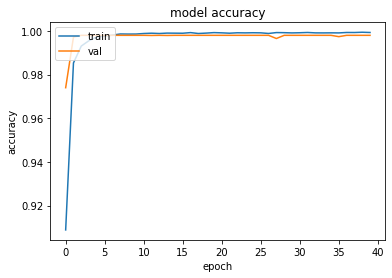

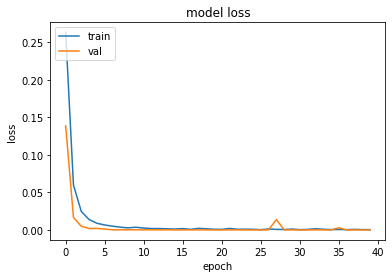

In [ ]:
liveness_model = entrenamiento_modelo_LDFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
dataset_traing = "CASIA"
model_path = BASE_FLDAS + "liveness_{}.model".format(dataset_traing)
liveness_model = tf.keras.models.load_model(model_path)

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 525.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 544.36it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.26it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.02it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.77it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.58it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 538.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 538.70it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 525.40it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_10.csv


100%|██████████| 635/635 [00:01<00:00, 622.38it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.16it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:01<00:00, 591.33it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 540.76it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 543.92it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:03<00:00, 557.42it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 524.92it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.19it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.25it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:03<00:00, 525.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 525.67it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.87it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.87it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.96it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 535.42it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:03<00:00, 520.25it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:03<00:00, 516.55it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [00:03<00:00, 533.56it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.32it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.86it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.84it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [00:03<00:00, 535.87it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.80it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.83it/s]


In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_17.csv


100%|██████████| 1999/1999 [00:03<00:00, 528.96it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_11.csv


100%|██████████| 1998/1998 [00:03<00:00, 521.82it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_9.csv


100%|██████████| 1995/1995 [00:03<00:00, 537.64it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_8.csv


100%|██████████| 1999/1999 [00:03<00:00, 531.96it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_12.csv


100%|██████████| 1998/1998 [00:03<00:00, 524.88it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.79it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_10.csv


100%|██████████| 1998/1998 [00:03<00:00, 532.24it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_14.csv


100%|██████████| 1999/1999 [00:03<00:00, 523.20it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_20.csv


100%|██████████| 40/40 [00:00<00:00, 630.08it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 515.97it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:03<00:00, 514.43it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_16.csv


100%|██████████| 1997/1997 [00:03<00:00, 523.41it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_0.csv


100%|██████████| 1999/1999 [00:03<00:00, 520.22it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 513.82it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_2.csv


100%|██████████| 1999/1999 [00:03<00:00, 530.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_1.csv


100%|██████████| 1999/1999 [00:03<00:00, 522.23it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_3.csv


100%|██████████| 1997/1997 [00:03<00:00, 527.05it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_4.csv


100%|██████████| 1999/1999 [00:03<00:00, 532.81it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_6.csv


100%|██████████| 1998/1998 [00:03<00:00, 524.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_5.csv


100%|██████████| 1997/1997 [00:03<00:00, 525.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_7.csv


100%|██████████| 1999/1999 [00:03<00:00, 527.03it/s]


#### Dataset de StyleGAN

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [ ]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 552/552 [02:19<00:00,  3.96it/s]


(82260, 3072)
(82260, 2)


In [ ]:
dataset_traing = "StyleGAN"
modelo = "LDFAS"
epochs = 40

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 84/84 [00:46<00:00,  1.82it/s]


In [ ]:
X_train.shape

(20949, 3072)

In [ ]:
y_train = y_train[:X_train.shape[0]]
y_train.shape

(20949, 2)

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [ ]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train.shape[0]]

In [ ]:
X_sub_CASIA = X_train_CASIA[indices]
X_sub_CASIA.shape

(20949, 3072)

In [ ]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

(20949, 2)

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [ ]:
X_train = np.concatenate((X_train, X_sub_CASIA))
X_train.shape

(41898, 3072)

In [ ]:
X = np.zeros((X_train.shape[0], 32, 32, 3), dtype=np.float)
count = 0
for row in tqdm(X_train):
    X[count] = row.reshape(32, 32, 3)
    count += 1

X_train = X
X_train.shape

100%|██████████| 41898/41898 [00:00<00:00, 116789.44it/s]


(41898, 32, 32, 3)

In [ ]:
y_train = np.concatenate((y_train, y_sub_CASIA))
y_train.shape

(41898, 2)

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(33518, 32, 32, 3)
(8380, 32, 32, 3)
(33518, 2)
(8380, 2)


Entrenamiento del modelo

Epoch 1/40
1048/1048 [==============================] - 50s 47ms/step - loss: 0.5487 - accuracy: 0.7533 - val_loss: 0.4049 - val_accuracy: 0.8765
Epoch 2/40
1048/1048 [==============================] - 49s 47ms/step - loss: 0.2373 - accuracy: 0.9389 - val_loss: 0.1519 - val_accuracy: 0.9814
Epoch 3/40
1048/1048 [==============================] - 49s 47ms/step - loss: 0.1149 - accuracy: 0.9741 - val_loss: 0.0889 - val_accuracy: 0.9852
Epoch 4/40
1048/1048 [==============================] - 49s 47ms/step - loss: 0.0705 - accuracy: 0.9827 - val_loss: 0.0546 - val_accuracy: 0.9937
Epoch 5/40
1048/1048 [==============================] - 49s 47ms/step - loss: 0.0483 - accuracy: 0.9876 - val_loss: 0.0179 - val_accuracy: 0.9977
Epoch 6/40
1048/1048 [==============================] - 49s 47ms/step - loss: 0.0349 - accuracy: 0.9903 - val_loss: 0.0311 - val_accuracy: 0.9973
Epoch 7/40
1048/1048 [==============================] - 49s 47ms/step - loss: 0.0266 - accuracy: 0.9927 - val_loss: 0.0267 -

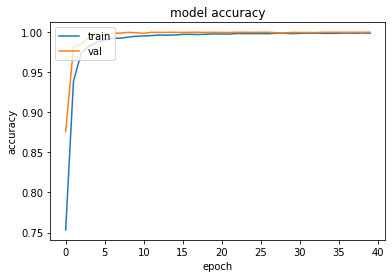

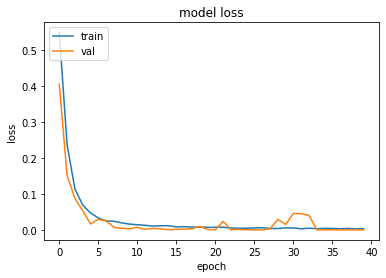

In [ ]:
liveness_model = entrenamiento_modelo_LDFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
dataset_traing = "StyleGAN"
model_path = BASE_FLDAS + "liveness_{}.model".format(dataset_traing)
liveness_model = tf.keras.models.load_model(model_path)

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 533.16it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.34it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 536.56it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 530.38it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.07it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 533.70it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 527.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.52it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_10.csv


100%|██████████| 635/635 [00:01<00:00, 592.74it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 517.62it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 522.69it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:03<00:00, 546.99it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 527.21it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:01<00:00, 594.26it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 538.21it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [00:03<00:00, 521.97it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 512.67it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 521.66it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 525.37it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 530.17it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 521.13it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 532.64it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 511.42it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 530.33it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 528.06it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.40it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.51it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:03<00:00, 527.42it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.79it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.08it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 520.06it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.66it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 521.94it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [00:03<00:00, 525.50it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [00:03<00:00, 516.64it/s]


In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_1.csv


100%|██████████| 1999/1999 [00:03<00:00, 534.34it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_11.csv


100%|██████████| 1998/1998 [00:03<00:00, 513.18it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_2.csv


100%|██████████| 1999/1999 [00:03<00:00, 529.86it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_3.csv


100%|██████████| 1997/1997 [00:03<00:00, 528.04it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_12.csv


100%|██████████| 1998/1998 [00:03<00:00, 528.04it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.93it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_4.csv


100%|██████████| 1999/1999 [00:03<00:00, 512.25it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_5.csv


100%|██████████| 1997/1997 [00:03<00:00, 527.68it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_14.csv


100%|██████████| 1999/1999 [00:03<00:00, 508.71it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 530.53it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_16.csv


100%|██████████| 1997/1997 [00:03<00:00, 518.11it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_6.csv


100%|██████████| 1998/1998 [00:03<00:00, 520.63it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_0.csv


100%|██████████| 1999/1999 [00:03<00:00, 522.04it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_20.csv


100%|██████████| 40/40 [00:00<00:00, 700.09it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_17.csv


100%|██████████| 1999/1999 [00:03<00:00, 537.92it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:03<00:00, 522.91it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.29it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_7.csv


100%|██████████| 1999/1999 [00:03<00:00, 527.40it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_8.csv


100%|██████████| 1999/1999 [00:03<00:00, 527.93it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_9.csv


100%|██████████| 1995/1995 [00:03<00:00, 538.68it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_10.csv


100%|██████████| 1998/1998 [00:03<00:00, 524.17it/s]


#### Todos los DataSets

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [183]:
modelo = "LDFAS"
epochs = 40

In [ ]:
dataset_traing = "DIFFUSION"
X_train_DIFFUSION, y_train_DIFFUSION = get_files(dataset_traing, modelo)

100%|██████████| 46/46 [00:10<00:00,  4.57it/s]

In [ ]:
dataset_traing = "CASIA"
X_train_CASIA, y_train_CASIA = get_files(dataset_traing, modelo)

In [ ]:
dataset_traing = "StyleGAN"
X_train_StyleGAN, y_train_StyleGAN = get_files(dataset_traing, modelo)

In [ ]:
y_train_StyleGAN = y_train_StyleGAN[:X_train_StyleGAN.shape[0]]

In [ ]:
dataset_traing = "SUBSTITUTION"
X_train_SUBSTITUTION, y_train_SUBSTITUTION = get_files(dataset_traing, modelo)

In [ ]:
X_train = np.concatenate((X_train_DIFFUSION, X_train_CASIA))
y_train = np.concatenate((y_train_DIFFUSION, y_train_CASIA))

In [ ]:
X_train = np.concatenate((X_train, X_train_StyleGAN))
y_train = np.concatenate((y_train, y_train_StyleGAN))

In [ ]:
X_train = np.concatenate((X_train, X_train_SUBSTITUTION))
y_train = np.concatenate((y_train, y_train_SUBSTITUTION))

In [ ]:
print(X_train_DIFFUSION.shape, y_train_DIFFUSION.shape)
print(X_train_CASIA.shape, y_train_CASIA.shape)
print(X_train_StyleGAN.shape, y_train_StyleGAN.shape)
print(X_train_SUBSTITUTION.shape, y_train_SUBSTITUTION.shape)

Datasets de validación

In [ ]:
X = np.zeros((X_train.shape[0], 32, 32, 3), dtype=np.float)
count = 0
for row in tqdm(X_train):
    X[count] = row.reshape(32, 32, 3)
    count += 1

X_train = X
X_train.shape

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

Entrenamiento del modelo

Epoch 1/40
3271/3271 [==============================] - 163s 50ms/step - loss: 0.3272 - accuracy: 0.8777 - val_loss: 0.1247 - val_accuracy: 0.9714
Epoch 2/40
3271/3271 [==============================] - 161s 49ms/step - loss: 0.0940 - accuracy: 0.9704 - val_loss: 0.0499 - val_accuracy: 0.9894
Epoch 3/40
3271/3271 [==============================] - 175s 53ms/step - loss: 0.0646 - accuracy: 0.9793 - val_loss: 0.0389 - val_accuracy: 0.9886
Epoch 4/40
3271/3271 [==============================] - 152s 47ms/step - loss: 0.0499 - accuracy: 0.9839 - val_loss: 0.0360 - val_accuracy: 0.9897
Epoch 5/40
3271/3271 [==============================] - 153s 47ms/step - loss: 0.0445 - accuracy: 0.9850 - val_loss: 0.0312 - val_accuracy: 0.9922
Epoch 6/40
3271/3271 [==============================] - 154s 47ms/step - loss: 0.0397 - accuracy: 0.9867 - val_loss: 0.0341 - val_accuracy: 0.9902
Epoch 7/40
3271/3271 [==============================] - 165s 50ms/step - loss: 0.0362 - accuracy: 0.9881 - val_loss: 0

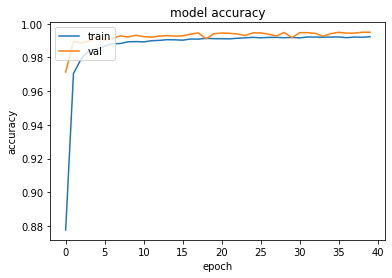

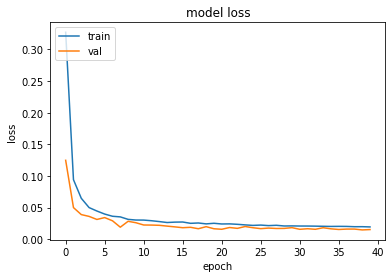

In [ ]:
dataset_traing = "ALL"
liveness_model = entrenamiento_modelo_LDFAS(X_train, y_train, X_val, y_val)

Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
dataset_traing = "ALL"

In [ ]:
#@title
model_path = BASE_FLDAS + "liveness_{}.model".format(dataset_traing)
liveness_model = tf.keras.models.load_model(model_path)

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:04<00:00, 483.02it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:04<00:00, 489.35it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:04<00:00, 496.62it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 532.37it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 538.69it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 521.25it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 537.49it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 544.94it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 544.78it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_10.csv


100%|██████████| 635/635 [00:01<00:00, 594.00it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [19:27<00:00,  1.43it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [23:48<00:00,  1.40it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [24:22<00:00,  1.37it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_3.csv


100%|██████████| 694/694 [08:23<00:00,  1.38it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_2.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 521.57it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_0.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 518.36it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_3.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 513.66it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_1.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 518.30it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_4.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 522.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_5.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 519.32it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_7.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 524.84it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_8.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 523.97it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_11.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 527.81it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_6.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 525.02it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_10.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 510.89it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_12.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 525.35it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_9.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 516.44it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_13.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 520.35it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_14.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 522.79it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_15.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 523.83it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_16.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 527.30it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_18.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 517.62it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_17.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 526.83it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_19.csv.bak


100%|██████████| 2000/2000 [00:03<00:00, 521.59it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.61it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.71it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:11<00:00, 168.05it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [00:12<00:00, 166.57it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.82it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.29it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.20it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.79it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.96it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [00:12<00:00, 166.33it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:11<00:00, 168.21it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:11<00:00, 166.69it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:11<00:00, 168.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:11<00:00, 168.84it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [00:12<00:00, 157.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [00:14<00:00, 138.51it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [00:15<00:00, 132.02it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [00:11<00:00, 169.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [00:11<00:00, 167.55it/s]


In [ ]:
#@title
eval_dataset(RESULT_StyleGAN, dataset_traing, False, True, False)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_14.csv


100%|██████████| 1999/1999 [00:03<00:00, 514.95it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_0.csv


100%|██████████| 1999/1999 [00:03<00:00, 526.07it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_16.csv


100%|██████████| 1997/1997 [00:03<00:00, 520.62it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_20.csv


100%|██████████| 40/40 [00:00<00:00, 425.14it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_17.csv


100%|██████████| 1999/1999 [00:03<00:00, 519.17it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.80it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:03<00:00, 517.08it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.19it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.45it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_9.csv


100%|██████████| 1995/1995 [00:03<00:00, 534.53it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_11.csv


100%|██████████| 1998/1998 [00:03<00:00, 520.24it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_10.csv


100%|██████████| 1998/1998 [00:03<00:00, 520.47it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_3.csv


100%|██████████| 1997/1997 [00:03<00:00, 523.14it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_2.csv


100%|██████████| 1999/1999 [00:03<00:00, 532.89it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_12.csv


100%|██████████| 1998/1998 [00:03<00:00, 528.59it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_5.csv


100%|██████████| 1997/1997 [00:03<00:00, 526.27it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_8.csv


100%|██████████| 1999/1999 [00:03<00:00, 519.25it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_7.csv


100%|██████████| 1999/1999 [00:03<00:00, 526.33it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_6.csv


100%|██████████| 1998/1998 [00:03<00:00, 522.51it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_4.csv


100%|██████████| 1999/1999 [00:03<00:00, 526.39it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_1.csv


100%|██████████| 1999/1999 [00:03<00:00, 539.27it/s]


## Algoritmo Object FAS

### Entrenamiento del modelo

In [159]:
def entrenamiento_modelo_OFAS(X_train, y_train, X_val, y_val):
    clf = jb.load(model_path)
    print(model_path)
    clf.set_params(max_samples=100, ccp_alpha=0.0)
    # Random Forest CLASSIFIER
    print("Training data ETC")
    clf_temp = ExtraTreesClassifier(n_estimators=10, min_samples_leaf=10, n_jobs=8)
    params = {"bootstrap":clf.bootstrap, 
          "ccp_alpha":clf.ccp_alpha,
          "class_weight":clf.class_weight,
          "criterion":clf.criterion, 
          "max_depth":clf.max_depth, 
          "max_features":clf.max_features,
          "max_leaf_nodes":clf.max_leaf_nodes, 
          "max_samples":clf.max_samples,
          "min_impurity_decrease":clf.min_impurity_decrease, 
          "min_impurity_split":clf.min_impurity_split,
          "min_samples_leaf":clf.min_samples_leaf, 
          "min_samples_split":clf.min_samples_split,
          "min_weight_fraction_leaf":clf.min_weight_fraction_leaf, 
          "n_estimators":clf.n_estimators, 
          "n_jobs":clf.n_jobs,
          "oob_score":clf.oob_score, 
          "random_state":clf.random_state, 
          "verbose":clf.verbose,
          "warm_start":clf.warm_start}
    clf_temp.set_params(**params)
    clf_temp.estimators_ = clf.estimators_

    start_time = time.time()
    clf_temp.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    print("ExtraTreesClassifier %.3f s" % elapsed_time)

    # Computing the importance of each feature
    feature_importance = clf_temp.feature_importances_

    # Normalizing the individual importances
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                            clf_temp.estimators_],
                                            axis = 0)

    seed = 0

    cv = KFold(n_splits=10, random_state=seed, shuffle=True)
    scores = cross_val_score(clf_temp, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=8)
    print('Accuraccy: ', mean(scores))
    # print(scores)

    cv = KFold(n_splits=10, random_state=seed, shuffle=True)
    scores = cross_val_score(clf_temp, X_val, y_val, scoring='accuracy', cv=cv, n_jobs=8)
    print('Accuraccy validación: ', mean(scores))
    # print(scores)

    cv = KFold(n_splits=10, random_state=seed, shuffle=True)
    scores = cross_val_predict(clf_temp, X_val, y_val, cv=cv, n_jobs=8)
    # print(y_val)
    # print(scores)

    jb.dump(clf, os.path.join(BASE_O_FAS, "{}_extraTreesClassifier.pkl".format(dataset_traing)))
    print("Generated:", os.path.join(BASE_O_FAS, "{}_extraTreesClassifier.pkl".format(dataset_traing)))

    return clf_temp

In [161]:
BASE_FSDO = BASE_CODIGOS + "/2_Objects_FAS/"

model_path = BASE_FSDO + "trained_models/replay_attack_trained_models/replay-attack_ycrcb_luv_extraTreesClassifier.pkl"

# load our serialized face detector from disk
print('[INFO] loading face detector...')
faceClassif = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
clf = jb.load(model_path)

[INFO] loading face detector...


### Lectura de archivos de pruebas para ser clasificados

In [122]:
def get_data_CASIA():
    X_train_CASIA, y_train_CASIA = get_files("CASIA", "OFAS")
    print(X_train_CASIA.shape)
    print(y_train_CASIA.shape)
    return X_train_CASIA, y_train_CASIA

#### Dataset de DIFFUSION

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [146]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 552/552 [00:48<00:00, 11.43it/s]


(82260, 1536)
(82260, 1)


In [147]:
dataset_traing = "DIFFUSION"
modelo = "OFAS"

In [148]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 46/46 [00:03<00:00, 11.70it/s]


In [149]:
X_train.shape

(6671, 1536)

In [150]:
y_train.shape

(6671, 1)

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [151]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train.shape[0]]

In [152]:
X_sub_CASIA = X_train_CASIA[indices]
X_sub_CASIA.shape

(6671, 1536)

In [153]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

(6671, 1)

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [154]:
X_train = np.concatenate((X_train, X_sub_CASIA))
X_train.shape

(13342, 1536)

In [155]:
y_train = np.concatenate((y_train, y_sub_CASIA))
y_train.shape

(13342, 1)

Datasets de validación

In [156]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [157]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(10673, 1536)
(2669, 1536)
(10673, 1)
(2669, 1)


Entrenamiento del modelo

In [162]:
clf = entrenamiento_modelo_OFAS(X_train, y_train, X_val, y_val)

/content/Prototipo/Codigos/2_Objects_FAS/trained_models/replay_attack_trained_models/replay-attack_ycrcb_luv_extraTreesClassifier.pkl
Training data ETC
ExtraTreesClassifier 0.359 s
Accuraccy:  0.9923178852114333
Accuraccy validación:  0.9617794486215538
Generated: /content/Prototipo/Codigos/2_Objects_FAS/DIFFUSION_extraTreesClassifier.pkl


Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, False, True)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_3.csv


100%|██████████| 2000/2000 [28:51<00:00,  1.16it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_10.csv


100%|██████████| 635/635 [09:40<00:00,  1.09it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_2.csv


 39%|███▉      | 778/2000 [11:51<19:06,  1.07it/s]

In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, False, True)

In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, False, True)

In [ ]:
#@title

eval_dataset(RESULT_StyleGAN, dataset_traing, False, False, True)

#### Dataset de SUBSTITUTION

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [ ]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

In [ ]:
dataset_traing = "SUBSTITUTION"
modelo = "OFAS"

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 46/46 [00:03<00:00, 13.70it/s]


In [ ]:
X_train.shape

(6671, 1536)

In [ ]:
y_train.shape

(6671, 1)

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [ ]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train.shape[0]]

In [ ]:
X_sub_CASIA = X_train_CASIA[indices]
X_sub_CASIA.shape

(6671, 1536)

In [ ]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

(6671, 1)

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [ ]:
X_train = np.concatenate((X_train, X_sub_CASIA))
X_train.shape

(13342, 1536)

In [ ]:
y_train = np.concatenate((y_train, y_sub_CASIA))
y_train.shape

(13342, 1)

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(10673, 1536)
(2669, 1536)
(10673, 1)
(2669, 1)


Entrenamiento del modelo

In [ ]:
clf = entrenamiento_modelo_OFAS(X_train, y_train, X_val, y_val)

Training data ETC
ExtraTreesClassifier 0.245 s
Accuraccy:  0.9976572454534924
Accuraccy validación:  0.9887570048717299
Generated: /content/drive/MyDrive/TESIS/Prototipo/Codigos/FAS/2_Objects_FAS/DIFFUSION_extraTreesClassifier.pkl


Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, False, True)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_3.csv


100%|██████████| 2000/2000 [28:51<00:00,  1.16it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_10.csv


 52%|█████▏    | 330/635 [05:02<04:40,  1.09it/s]

In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, False, True)

In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, False, True)

In [ ]:
#@title

eval_dataset(RESULT_StyleGAN, dataset_traing, False, False, True)

#### Dataset de CASIA

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [ ]:
dataset_traing = "CASIA"
modelo = "OFAS"

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 46/46 [00:03<00:00, 13.70it/s]


In [ ]:
X_train.shape

(6671, 1536)

In [ ]:
y_train.shape

(6671, 1)

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(10673, 1536)
(2669, 1536)
(10673, 1)
(2669, 1)


Entrenamiento del modelo

In [ ]:
clf = entrenamiento_modelo_OFAS(X_train, y_train, X_val, y_val)

Training data ETC
ExtraTreesClassifier 0.245 s
Accuraccy:  0.9976572454534924
Accuraccy validación:  0.9887570048717299
Generated: /content/drive/MyDrive/TESIS/Prototipo/Codigos/FAS/2_Objects_FAS/DIFFUSION_extraTreesClassifier.pkl


Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, False, True)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_3.csv


100%|██████████| 2000/2000 [28:51<00:00,  1.16it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_10.csv


 52%|█████▏    | 330/635 [05:02<04:40,  1.09it/s]

In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, False, True)

In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, False, True)

In [ ]:
#@title

eval_dataset(RESULT_StyleGAN, dataset_traing, False, False, True)

#### Dataset de StyleGAN

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [ ]:
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 552/552 [01:04<00:00,  8.54it/s]


(82260, 1536)
(82260, 1)


In [ ]:
dataset_traing = "StyleGAN"
modelo = "OFAS"

In [ ]:
X_train, y_train = get_files(dataset_traing, modelo)

100%|██████████| 84/84 [00:50<00:00,  1.66it/s]


In [ ]:
X_train.shape

(20942, 1536)

In [ ]:
y_train.shape

(20942, 1)

Capturar reales con la misma cantidad del dataset de entrenamiento para balanceo

In [ ]:
indices = np.where(y_train_CASIA == 1)
indices =  indices[0][:X_train.shape[0]]
print(len(indices))

20753


In [ ]:
X_sub_CASIA = X_train_CASIA[indices]
X_sub_CASIA.shape

(20753, 1536)

In [ ]:
y_sub_CASIA = y_train_CASIA[indices]
y_sub_CASIA.shape

(20753, 1)

concatenación de dataset CASIA_REALES con dataset de entrenamiento

In [ ]:
X_train = np.concatenate((X_train, X_sub_CASIA))
X_train.shape

(41695, 1536)

In [ ]:
y_train = np.concatenate((y_train, y_sub_CASIA))
y_train.shape

(41695, 1)

Datasets de validación

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(33356, 1536)
(8339, 1536)
(33356, 1)
(8339, 1)


Entrenamiento del modelo

In [ ]:
clf = entrenamiento_modelo_OFAS(X_train, y_train, X_val, y_val)

Training data ETC
ExtraTreesClassifier 1.227 s
Accuraccy:  0.998950659562305
Accuraccy validación:  0.9960428775826877
Generated: /content/drive/MyDrive/TESIS/Prototipo/Codigos/FAS/2_Objects_FAS/StyleGAN_extraTreesClassifier.pkl


Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, False, True)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_0.csv


100%|██████████| 2000/2000 [00:04<00:00, 462.26it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_1.csv


100%|██████████| 2000/2000 [00:04<00:00, 475.69it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 510.16it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 517.25it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_4.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.58it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_5.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.71it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 525.51it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 529.16it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 505.10it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 521.06it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_10.csv


100%|██████████| 635/635 [00:01<00:00, 581.54it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, False, True)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_0.csv


100%|██████████| 1674/1674 [00:03<00:00, 551.03it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 540.84it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 532.64it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_3.csv


100%|██████████| 694/694 [00:01<00:00, 625.95it/s]


In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, False, True)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_0.csv


100%|██████████| 2000/2000 [00:03<00:00, 511.60it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_1.csv


100%|██████████| 2000/2000 [00:03<00:00, 523.00it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_2.csv


100%|██████████| 2000/2000 [00:03<00:00, 507.77it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_3.csv


100%|██████████| 2000/2000 [00:03<00:00, 503.79it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_4.csv


100%|██████████| 2000/2000 [00:04<00:00, 496.14it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_5.csv


100%|██████████| 2000/2000 [00:04<00:00, 494.11it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_6.csv


100%|██████████| 2000/2000 [00:03<00:00, 507.41it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_7.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.19it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_8.csv


100%|██████████| 2000/2000 [00:03<00:00, 526.15it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_9.csv


100%|██████████| 2000/2000 [00:03<00:00, 517.95it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_10.csv


100%|██████████| 2000/2000 [00:03<00:00, 513.50it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_11.csv


100%|██████████| 2000/2000 [00:04<00:00, 462.04it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_12.csv


100%|██████████| 2000/2000 [00:04<00:00, 498.51it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 524.01it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_14.csv


100%|██████████| 2000/2000 [00:03<00:00, 517.21it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 503.04it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_16.csv


100%|██████████| 2000/2000 [00:03<00:00, 524.35it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_17.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.47it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_18.csv


100%|██████████| 2000/2000 [00:03<00:00, 518.99it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 531.46it/s]


In [ ]:
#@title

eval_dataset(RESULT_StyleGAN, dataset_traing, False, False, True)

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_6.csv


100%|██████████| 1998/1998 [00:03<00:00, 539.45it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_7.csv


100%|██████████| 1999/1999 [00:03<00:00, 530.68it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_8.csv


100%|██████████| 1999/1999 [00:03<00:00, 538.72it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_9.csv


100%|██████████| 1995/1995 [00:03<00:00, 522.09it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_10.csv


100%|██████████| 1998/1998 [00:03<00:00, 538.04it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_11.csv


100%|██████████| 1998/1998 [00:03<00:00, 529.34it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_12.csv


100%|██████████| 1998/1998 [00:03<00:00, 520.18it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_13.csv


100%|██████████| 2000/2000 [00:03<00:00, 521.94it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_14.csv


100%|██████████| 1999/1999 [00:03<00:00, 519.57it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_15.csv


100%|██████████| 2000/2000 [00:03<00:00, 539.47it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_16.csv


100%|██████████| 1997/1997 [00:03<00:00, 531.14it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_17.csv


100%|██████████| 1999/1999 [00:03<00:00, 534.58it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_18.csv


100%|██████████| 1993/1993 [00:03<00:00, 523.05it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_19.csv


100%|██████████| 2000/2000 [00:03<00:00, 527.35it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_20.csv


100%|██████████| 40/40 [00:00<00:00, 632.05it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_0.csv


100%|██████████| 1999/1999 [00:03<00:00, 526.57it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_1.csv


100%|██████████| 1999/1999 [00:03<00:00, 525.75it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_2.csv


100%|██████████| 1999/1999 [00:03<00:00, 526.48it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_3.csv


100%|██████████| 1997/1997 [00:03<00:00, 539.49it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_4.csv


100%|██████████| 1999/1999 [00:03<00:00, 533.09it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_5.csv


100%|██████████| 1997/1997 [00:03<00:00, 517.14it/s]


#### Todos los DataSets

*   Datos con el que fue entrenado = "CASIA"
*   Evaluar con SFAS = True
*   Evaluar con LDFAS = False
*   Evaluar con OFAS = False

In [166]:
modelo = "OFAS"

In [167]:
dataset_traing = "DIFFUSION"
X_train_DIFFUSION, y_train_DIFFUSION = get_files(dataset_traing, modelo)

100%|██████████| 46/46 [00:03<00:00, 11.84it/s]


In [168]:
dataset_traing = "CASIA"
X_train_CASIA, y_train_CASIA = get_data_CASIA()

100%|██████████| 552/552 [00:48<00:00, 11.40it/s]


(82260, 1536)
(82260, 1)


In [169]:
dataset_traing = "StyleGAN"
X_train_StyleGAN, y_train_StyleGAN = get_files(dataset_traing, modelo)

100%|██████████| 84/84 [00:11<00:00,  7.31it/s]


In [172]:
dataset_traing = "SUBSTITUTION"
X_train_SUBSTITUTION, y_train_SUBSTITUTION = get_files(dataset_traing, modelo)

100%|██████████| 140/140 [00:12<00:00, 10.77it/s]


In [175]:
X_train = np.concatenate((X_train_DIFFUSION, X_train_CASIA))
y_train = np.concatenate((y_train_DIFFUSION, y_train_CASIA))

In [177]:
X_train = np.concatenate((X_train, X_train_StyleGAN))
y_train = np.concatenate((y_train, y_train_StyleGAN))

In [178]:
X_train = np.concatenate((X_train, X_train_SUBSTITUTION))
y_train = np.concatenate((y_train, y_train_SUBSTITUTION))

Datasets de validación

In [179]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8)

In [180]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(104641, 1536)
(26161, 1536)
(104641, 1)
(26161, 1)


Entrenamiento del modelo

In [181]:
dataset_traing = "ALL"

In [182]:
clf = entrenamiento_modelo_OFAS(X_train, y_train, X_val, y_val)

/content/Prototipo/Codigos/2_Objects_FAS/trained_models/replay_attack_trained_models/replay-attack_ycrcb_luv_extraTreesClassifier.pkl
Training data ETC
ExtraTreesClassifier 6.777 s
Accuraccy:  0.840597842524448
Accuraccy validación:  0.8405262755051364
Generated: /content/Prototipo/Codigos/2_Objects_FAS/ALL_extraTreesClassifier.pkl


Validar los dataset con el modelo reentrenado

*   Dataset a evaluar = RESULT_CASIA
*   Datos con el que fue entrenado = "DIFFUSION"
*   Evaluar con SFAS = False
*   Evaluar con LDFAS = True
*   Evaluar con OFAS = False

In [ ]:
#@title
eval_dataset(RESULT_CASIA, dataset_traing, False, False, True)

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_3.csv


100%|██████████| 2000/2000 [28:51<00:00,  1.16it/s]


/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_10.csv


 52%|█████▏    | 330/635 [05:02<04:40,  1.09it/s]

In [ ]:
#@title
eval_dataset(RESULT_CASIA_DIFFUSION, dataset_traing, False, False, True)

In [ ]:
#@title
eval_dataset(RESULT_CASIA_SUBSTITUTION, dataset_traing, False, False, True)

In [ ]:
#@title

eval_dataset(RESULT_StyleGAN, dataset_traing, False, False, True)